# German Credit Data Project

In [ ]:
# Author : gsanchz
# Date   : 12/2023

#### Fuente de los datos: https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)

## 0. Explora el cuaderno de Python *demo_german_credit_data.ipynb*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from IPython.display import HTML
import base64
from io import BytesIO
import re
from thefuzz import fuzz #Distancia de Levenshtein para comparar similitudes entre strings
import ppscore as pps

# imports para unas funciones cogidas de github
import math
from collections import Counter
import scipy.stats as ss

# Función que utilizaré para mostrar una miniatura de plots
def get_image_html(ax):
    fig = ax.figure # Cojo el lienzo sobre el que el objeto axes está dibujado

    buf = BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight') # Lo guardo en buffer en png
    data = base64.b64encode(buf.getbuffer()).decode('ascii') # Codifico y decodifico para obtener una cadena de texto legible
    buf.close()

    return f'<img src="data:image/png;base64,{data}" style="width: 200px; height: auto;" />'

In [2]:
# He querido hacer un ejercicio de expresiones regex aplicadas a código html

# Obtengo el código html de la web fuente de los datos
url = 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data'

def get_html(url):
    response = requests.get(url)
    if response.status_code == 200:
        html_text = response.text
        return html_text
    else:
        return f"Error en la solicitud:{str(response.status_code)}"
code = get_html(url)

In [3]:
# Mi objetivo es obtener la correspondencia de nombres entre los que
# salen en la web y los que salen en el dataframe así como las descripciones
# completas de los atributos que aparecen en la web

# Obtengo una lista cuyos elementos son toda la info disponible de cada atributo
regex = re.compile(r'((?:Attribute|Attibute) \d{1,2}.*?)(?:\r\n\r\n|\r\n</p>)',re.DOTALL)
atributes_list = re.findall(regex,code)

# Para cada atributo obtengo su nombre, así como el número y nombre de sus clases
list_class = []
for atribute in atributes_list:
    delimitadores = "\r\n\t(?!\t)|\r\n(?!\t\t)"
    partes = re.split(delimitadores, atribute)
    name = partes[1].strip()
    clases = partes[2:]
    if len(clases) > 0:
        regex_num = r'A\d{1,3}'
        regex_name = r'A\d{1,3} : (.*)'
        for clase in clases:
            class_num = re.findall(regex_num,clase)[0]
            class_name = re.findall(regex_name,clase)[0].replace('&lt;','<').replace('/\r\n\t\t','')
            list_class.append({'class_num':class_num,'class_web_name':class_name,'col_web_name':name})
            
    # Para aquellos atributos sin clases
    else:
        class_num = np.nan
        class_name = np.nan
        list_class.append({'class_num':class_num,'class_web_name':class_name,'col_web_name':name})

web_info = pd.DataFrame(list_class)
web_info

,class_num,class_web_name,col_web_name
0,A11,... < 0 DM,Status of existing checking account
1,A12,0 <= ... < 200 DM,Status of existing checking account
2,A13,... >= 200 DM / salary assignments for at...,Status of existing checking account
3,A14,no checking account,Status of existing checking account
4,NaN,NaN,Duration in month
...,...,...,...
58,NaN,NaN,Number of people being liable to provide maint...
59,A191,none,Telephone
60,A192,"yes, registered under the customers name",Telephone
61,A201,yes,foreign worker


In [4]:
# He querido hacer una automatización de la correspondencia entre los nombres
# de las columnas del dataframe y cómo aparecen estas nombradas en la web fuente
# de los datos. Para ello he utilizado fuzz que aplica la distancia de Levenshtein
# entre dos strings.

df = pd.read_csv('./datasets/german_credit_data.csv', sep=';')
df.columns = df.columns.str.strip() #Elimino espacios en los nombres de las columnas
cols = df.columns

col_similarity_dicc = {}
clase_similarity_dicc = {}

for df_col_name in cols:
    #Voy actualizando este par según encuentro una mejor traducción (mayor score)
    traduction = ['',0]
    for web_col_name in web_info['col_web_name']:
        similarity = fuzz.WRatio(df_col_name,web_col_name)
        
        #Una similaridad aceptable es por encima de 70
        if similarity > traduction[1] and similarity > 70:
            traduction = [web_col_name,similarity]
            
    #Añado la traducción de la columna del df al diccionario
    col_similarity_dicc[df_col_name] = traduction[0]
    

    #Hago lo mismo para el nombre de las clases de cada columna
    if df[df_col_name].dtype != 'int64':
        #Elimino espacios para evitar valores distintos por diferencia de espacios
        df[df_col_name] = df[df_col_name].str.strip()
        
        for clase in df[df_col_name].unique():
            web_col_name = col_similarity_dicc[df_col_name]
            traduction = ['',0]
            
            for web_clase in web_info[web_info['col_web_name']==web_col_name]['class_web_name']:
                similarity = fuzz.WRatio(clase,web_clase)
                if similarity > traduction[1] and similarity > 70:
                    traduction = [web_clase,similarity]
                    
            #Escogida la traducción de la clase, la guardo
            clase_similarity_dicc[clase] = traduction[0]

In [5]:
# Con los diccionarios construidos, mapeo el DataFrame existente para reflejar las correspondencias
# Hacemos el diccionario inverso porque queremos traducir de web a DataFrame
inverse_col_similarity_dicc = {value:key for key,value in col_similarity_dicc.items()}
inverse_clase_similarity_dicc = {value:key for key,value in clase_similarity_dicc.items()}

web_info['col_df_name'] = web_info['col_web_name'].map(inverse_col_similarity_dicc)
web_info['clase_df_name'] = web_info['class_web_name'].map(inverse_clase_similarity_dicc)
web_info

,class_num,class_web_name,col_web_name,col_df_name,clase_df_name
0,A11,... < 0 DM,Status of existing checking account,account_check_status,< 0 DM
1,A12,0 <= ... < 200 DM,Status of existing checking account,account_check_status,0 <= ... < 200 DM
2,A13,... >= 200 DM / salary assignments for at...,Status of existing checking account,account_check_status,>= 200 DM / salary assignments for at least 1 ...
3,A14,no checking account,Status of existing checking account,account_check_status,no checking account
4,NaN,NaN,Duration in month,duration_in_month,NaN
...,...,...,...,...,...
58,NaN,NaN,Number of people being liable to provide maint...,people_under_maintenance,NaN
59,A191,none,Telephone,telephone,none
60,A192,"yes, registered under the customers name",Telephone,telephone,"yes, registered under the customers name"
61,A201,yes,foreign worker,foreign_worker,yes


In [6]:
# Reemplazo los valores categóricos por las etiquetas que le ponen en la web

map_classes = {}

#He valorado que las siguientes columnas categóricas del DataFrame tienen un orden implícito
nom_ord = ['account_check_status','credit_history','savings','present_emp_since']

for col in df.columns:
    
    #DataFrame con toda la info de las clases de la columna tal y como sale nombrada en la web 
    subweb_info = web_info[web_info['col_df_name'] == col]
    
    #Hacemos un diccionario para traducir entre nombre de la clase en el DataFrame y etiqueta en la web
    rename_dicc = subweb_info[['clase_df_name','class_num']].set_index('clase_df_name').to_dict()['class_num']
    
    #Hacemos el reemplazo en el DataFrame original
    df[col] = df[col].replace(rename_dicc)
    
    #Para las columnas no numéricas, transformamos a tipo categórico
    if df[col].dtype != 'int64':
        df[col] = df[col].astype('category').cat.set_categories(new_categories=rename_dicc.values())
        
        #Para aquellas que tengan un orden natural implícito (nom_ord), establecemos un orden entre clases
        if col in nom_ord:
            df[col] = df[col].astype('category').cat.set_categories(new_categories=rename_dicc.values(),ordered=True)

#La columna default se entiende como otorgado (1) o no otorgado (0) por lo que escogemos que sea categórica
df['default'] = df['default'].astype(str).astype('category')
df

,default,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,...,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
0,0,A11,6,A34,A44,1169,A65,A75,4,A93,...,4,A121,67,A143,A152,2,A173,1,A192,A201
1,1,A12,48,A32,A44,5951,A61,A73,2,A92,...,2,A121,22,A143,A152,1,A173,1,A191,A201
2,0,A14,12,A34,A47,2096,A61,A74,2,A93,...,3,A121,49,A143,A152,1,A172,2,A191,A201
3,0,A11,42,A32,A43,7882,A61,A74,2,A93,...,4,A122,45,A143,A153,1,A173,2,A191,A201
4,1,A11,24,A33,A40,4870,A61,A73,3,A93,...,4,A124,53,A143,A153,2,A173,2,A191,A201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,A14,12,A32,A43,1736,A61,A74,3,A92,...,4,A121,31,A143,A152,1,A172,1,A191,A201
996,0,A11,30,A32,A41,3857,A61,A73,4,A91,...,4,A122,40,A143,A152,1,A174,1,A192,A201
997,0,A14,12,A32,A44,804,A61,A75,4,A93,...,4,A123,38,A143,A152,1,A173,1,A191,A201
998,1,A11,45,A32,A44,1845,A61,A73,4,A93,...,4,A124,23,A143,A153,1,A173,1,A192,A201


,column,description,nunique,unique,non_inc_class,%_nans,ord,html_plots,dtype,count,mean,std,min,25%,50%,75%,max,density_plots
1,account_check_status,Status of existing checking account,4,"[A11, A12, A13, A14]",,0.0,ord,,category,,,,,,,,,"AxesSubplot(0.125,0.125;0.775x0.755)"
13,age,Age in years,,,,0.0,,,int64,1000.0,35.55,11.38,19.0,27.0,33.0,42.0,75.0,"AxesSubplot(0.125,0.125;0.775x0.755)"
5,credit_amount,Credit amount,,,,0.0,,,int64,1000.0,3271.26,2822.74,250.0,1365.5,2319.5,3972.25,18424.0,"AxesSubplot(0.125,0.125;0.775x0.755)"
3,credit_history,Credit history,5,"[A30, A31, A32, A33, A34]",,0.0,ord,,category,,,,,,,,,"AxesSubplot(0.125,0.125;0.775x0.755)"
16,credits_this_bank,Number of existing credits at this bank,,,,0.0,,,int64,1000.0,1.41,0.58,1.0,1.0,1.0,2.0,4.0,"AxesSubplot(0.125,0.125;0.775x0.755)"
0,default,,2,"[0, 1]",,0.0,no_ord,,category,,,,,,,,,"AxesSubplot(0.125,0.125;0.775x0.755)"
2,duration_in_month,Duration in month,,,,0.0,,,int64,1000.0,20.9,12.06,4.0,12.0,18.0,24.0,72.0,"AxesSubplot(0.125,0.125;0.775x0.755)"
20,foreign_worker,foreign worker,2,"[A201, A202]",,0.0,no_ord,,category,,,,,,,,,"AxesSubplot(0.125,0.125;0.775x0.755)"
15,housing,Housing,3,"[A151, A152, A153]",,0.0,no_ord,,category,,,,,,,,,"AxesSubplot(0.125,0.125;0.775x0.755)"
8,installment_as_income_perc,Installment rate in percentage of disposable income,,,,0.0,,,int64,1000.0,2.97,1.12,1.0,2.0,3.0,4.0,4.0,"AxesSubplot(0.125,0.125;0.775x0.755)"

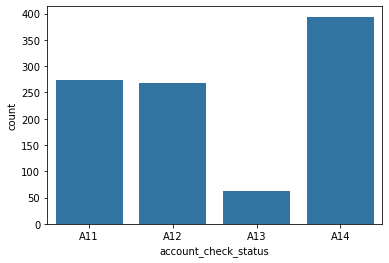
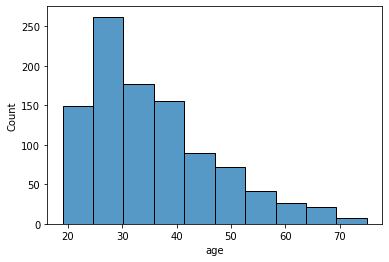
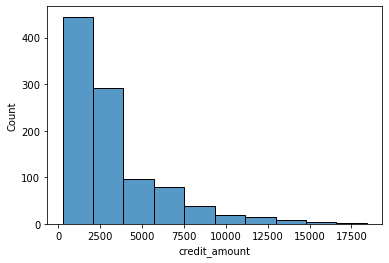
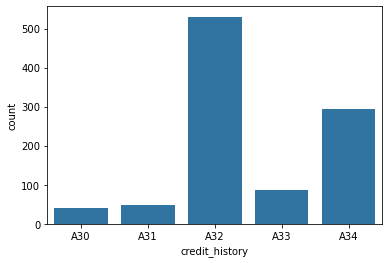
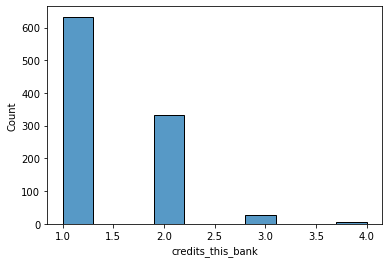
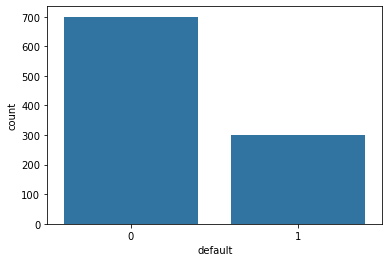
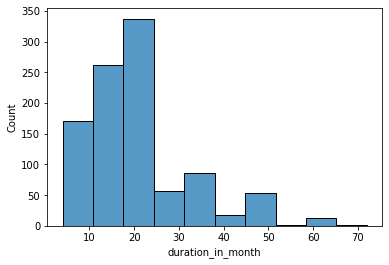
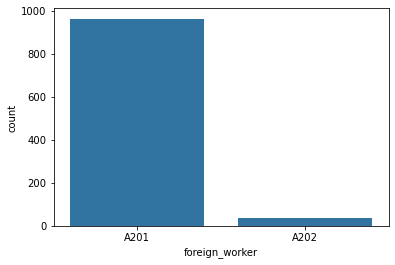
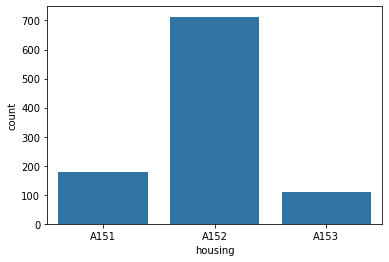
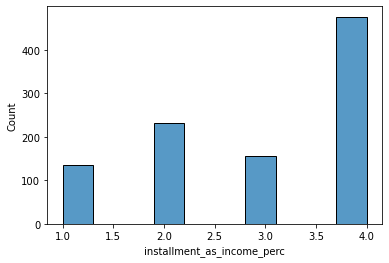
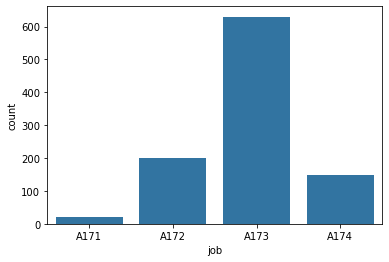
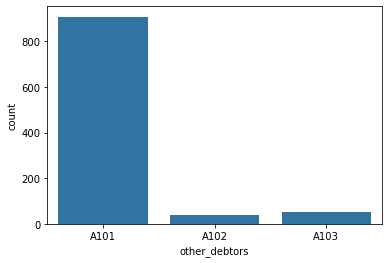
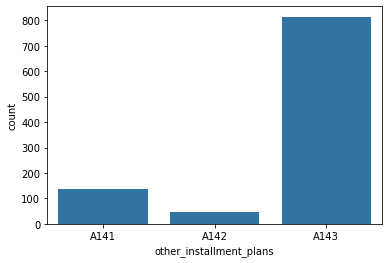
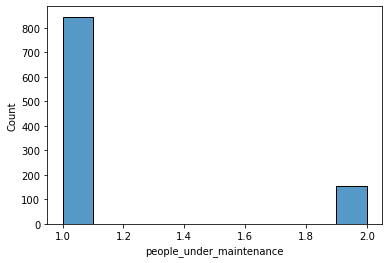
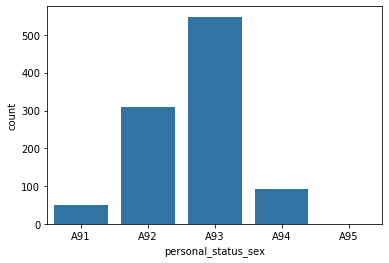
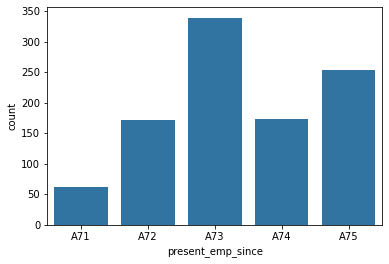
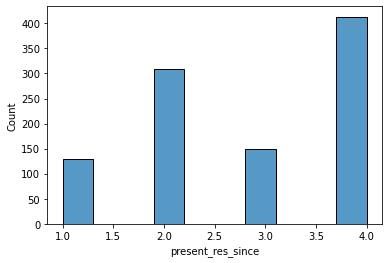
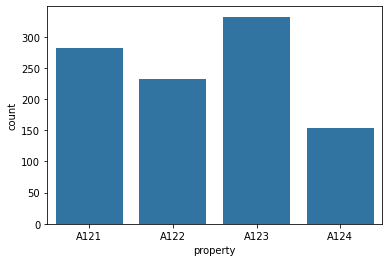
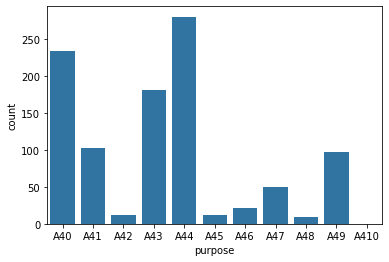
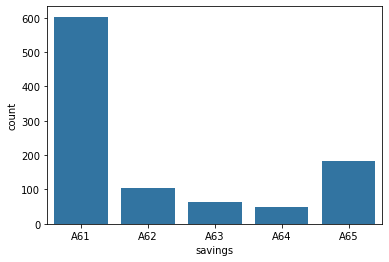
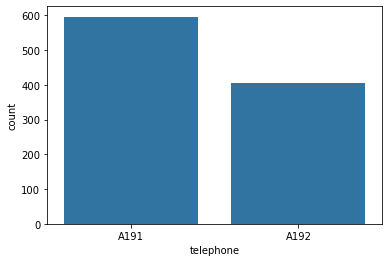

In [7]:
# Main characteristics of the DataFrame

nunique_list = []
unique_list = []
non_included_list = []
nom_ord_col = []
description = []
n_nan_list = [] # Store percentage of NaN records in each col
n_rec = df.shape[0] # Number of records
hist_plots = []

for col in cols:
    try:
        description.append((web_info.loc[web_info['col_df_name']==col,'col_web_name'].unique())[0])
    except:
        description.append('')
    
    #NaN values
    
    n_nan = df[col].isna().sum()
    n_nan_list.append(n_nan/n_rec)
    
    # Para crear una columna que diga si la columna es nominal ordenada o no
    if df[col].dtype =='category':
        nom_ord_col.append('no_ord')
    else:
        nom_ord_col.append('')
        
    if col in nom_ord:
        nom_ord_col[-1] = 'ord'


    #Para columnas no numéricas
    if df[col].dtype != 'int64':
        
        #Calculamos el countplot de sus clases
        plt.figure()
        hist_plots.append(sns.countplot(data=df,x=col))
        plt.close()
        
        #Values and n of values
        nunique_list.append(df[col].nunique())
        unique = sorted(df[col].unique())
        unique_list.append(unique)
        
        #Grabamos una columna con aquellas clases consideradas, pero no presentes en el DataFrame
        non_included = [class_num for class_num in web_info[web_info['col_df_name']==col]['class_num'] if class_num not in unique]
        if len(non_included) == 0:
            non_included = ''
        elif len(non_included) == 1:
            non_included = non_included[0]
        non_included_list.append(non_included)
    
    #Para columnas numéricas
    else:
        
        #Grabamos el histograma
        plt.figure()
        hist_plots.append(sns.histplot(df[col],bins=10))
        plt.close()
        
        #Prescindimos del conjunto de valores y su cardinal
        non_included_list.append('')
        nunique_list.append('')
        unique_list.append('')

#Construimos un DataFrame con toda la info
nunique_col_df = pd.DataFrame({'column':cols,\
                               'description':description,\
                               'nunique':nunique_list,\
                               'unique':unique_list,\
                               'non_inc_class':non_included_list,\
                               'density_plots':hist_plots,\
                               '%_nans':n_nan_list,\
                              'ord':nom_ord_col})

# Nueva columna para mostrar miniatura de los plots
nunique_col_df['html_plots'] = nunique_col_df['density_plots'].apply(get_image_html)

# Merge with dtype info del DataFrame
nunique_dtype_df = nunique_col_df.merge(df.dtypes.reset_index(),\
                                        left_on='column',\
                                        right_on='index').drop('index',axis=1).rename({0:'dtype'},axis=1)

# Guardamos un objeto Series con el nombre de aquellas columnas numéricas
numeric_columns = nunique_dtype_df[nunique_dtype_df['dtype']=='int64']['column']

# Y obtenemos información relevante de estas
df_describe = df.describe()

#Limpiamos el dataframe para una vista más limpia
for col in numeric_columns:
    if df_describe[col].dtype == float:
        df_describe[col] = df_describe[col].apply(round,args=(2,)) #Redondeo de las columnas con valores numéricos

#Transponemos para poder hacer merge
df_describe = df_describe.replace(0,'').transpose().reset_index().rename({'index':'column'},axis=1)


full_info = nunique_dtype_df.merge(df_describe,on='column',how='left').fillna('')
full_info = full_info.sort_values(by='column')
#Densito_plots al final
ordered_cols = [col for col in full_info.columns if col!='density_plots'] + ['density_plots']

#Pues va a haber una miniatura de los plots:
HTML(full_info[ordered_cols].to_html(escape=False, formatters=dict(html_plots=lambda x: x)))

## Correlación para variables categóricas
#Fuente: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

#Fuente: https://github.com/shakedzy/dython/blob/master/dython/nominal.py

#Fuente: https://www.blog.dailydoseofds.com/p/are-you-misinterpreting-correlation

- El **coeficiente de correlación de Pearson**:
    - Es obtenible para variables numéricas, pero no categóricas.
    - Entre -1 y 1, es una expresión de la **relación lineal** entre las dos variables.
- Utilizamos **Cramer's V** para saber la **causalidad** entre *dos variables categóricas*, dando por hecho que es una _causalidad simétrica_.
    - Valor entre 0 y 1.
- Para _causalidades no simétricas entre variables categóricas_ utilizamos **Theil's U**.
    - Valor entre 0 y 1.
    - Ejemplo de causalidad no simétrica: podemos establecer causalidad perfecta entre español -> europeo, pero la causalidad no existe para el caso europeo -> ¿? cuando en el dataset tengamos más de una nacionalidad europea.
- Para causalidades entre _una variable numérica y otra categórica_ utilizamos **Correlation Ratio**:
    - Dado un número ¿con qué certeza podemos asignarle a una clase especifica?
    - Ejemplo: Es verosimil asumir que los créditos concedidos de mayor cantidad estarán asignados a personas que tengan un historial crediticio más limpio (expresado esto como categoría).
    
No existe paquete y he sacado las funciones del repo de Github indicado en las Fuentes.
   

#### Otro enfoque para la predicción de variables categóricas: Predictive Power Score
Como su propio nombre indica, PPS indica cómo de poderosa es una variable categórica para predecir el valor de otra variable, ya sea esta numérica o categórica:

- Es asimétrica, como Theil's U.
- Se sirve del uso de los árboles regresores.
- Para predecir variables numéricas:
    - Entrena un árbol regresor tomando la variable categórica.
    - Toma el Mean Absolute Error del modelo y lo compara con el de otro modelo para obtener PPS
- Para predecir variables categóricas:
    - En vez de tomar el MAE, toma el F-Score del modelo entrenado y de uno base.
- Existe un paquete que implementa esto llamado ppscore

In [8]:

_REPLACE = "replace"
_DEFAULT_REPLACE_VALUE = 0.0

def replace_nan_with_value(x, y, value):
    x = np.array(
        [v if v == v and v is not None else value for v in x]
    )  # NaN != NaN
    y = np.array([v if v == v and v is not None else value for v in y])
    return x, y

def conditional_entropy(
    x,
    y,
    nan_strategy=_REPLACE,
    nan_replace_value=_DEFAULT_REPLACE_VALUE,
    log_base: float = math.e,
):
    """
    Calculates the conditional entropy of x given y: S(x|y)

    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy

    Parameters:
    -----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop' to remove samples
        with missing values, or 'replace' to replace all missing values with
        the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when
        nan_strategy is set to 'replace'.
    log_base: float, default = e
        specifying base for calculating entropy. Default is base e.

    Returns:
    --------
    float
    """
    if nan_strategy == _REPLACE:
        x, y = replace_nan_with_value(x, y, nan_replace_value)
    elif nan_strategy == _DROP:
        x, y = remove_incomplete_samples(x, y)
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y / p_xy, log_base)
    return entropy


def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x
    
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

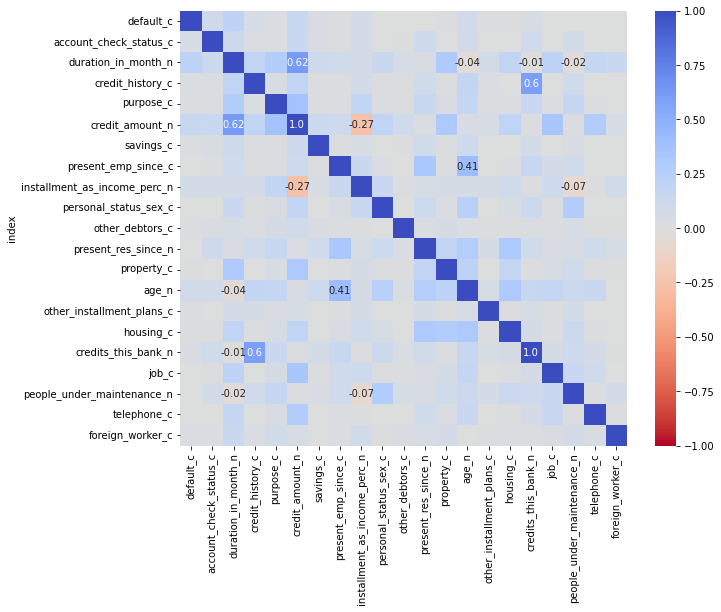

In [9]:
corr_matrix = []
index = []
type_suffix = {'int64':'_n','category':'_c'}
for col_i in df.columns:
    i_type = df[col_i].dtype
    index.append(col_i + type_suffix[str(i_type)])
    i = df[col_i]
    row_i = []
    for col_j in df.columns:
        j_type = df[col_j].dtype
        j = df[col_j]
        if i_type == 'int64' and j_type == 'int64':
            row_i.append(i.corr(j))
        elif i_type == 'category' and j_type == 'category':
            row_i.append(theils_u(i,j))
        else:
            cat, mea = (i, j) if i_type == 'category' else (j, i)
            row_i.append(correlation_ratio(cat,mea))
    corr_matrix.append(row_i)

    
corr_matrix = pd.DataFrame(corr_matrix)
corr_matrix['index'] = pd.Series(index)
corr_matrix = corr_matrix.set_index('index')
corr_matrix.columns = index

anotaciones = pd.DataFrame(np.where(((corr_matrix.abs() > 0.4)|(corr_matrix < 0))&(corr_matrix.abs() != 1), corr_matrix.round(2), ''))

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix,annot=anotaciones,fmt='s',cmap='coolwarm_r',vmin=-1,vmax=1)
plt.show()

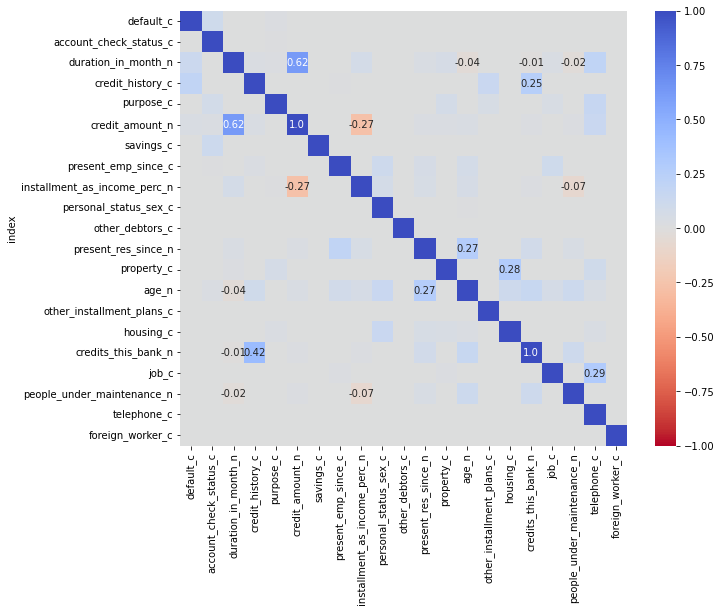

In [10]:
#Lo mismo, pero con ppscore en vez de con theils_u y correlation_ratio 

corr_matrix = []
index = []
for col_i in df.columns:
    i_type = df[col_i].dtype
    index.append(col_i + type_suffix[str(i_type)])
    i = df[col_i]
    row_i = []
    for col_j in df.columns:
        j_type = df[col_j].dtype
        j = df[col_j]
        if i_type == 'int64' and j_type == 'int64':
            row_i.append(i.corr(j))
        else:
            row_i.append(pps.score(df,col_i,col_j)['ppscore'])
    corr_matrix.append(row_i)


corr_matrix = pd.DataFrame(corr_matrix)
corr_matrix['index'] = pd.Series(index)
corr_matrix = corr_matrix.set_index('index')
corr_matrix.columns = index

anotaciones = pd.DataFrame(np.where(((corr_matrix.abs() > 0.25)|(corr_matrix < 0))&(corr_matrix.abs() != 1), corr_matrix.round(2), ''))

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix,annot=anotaciones,fmt='s',cmap='coolwarm_r',vmin=-1,vmax=1)
plt.show()

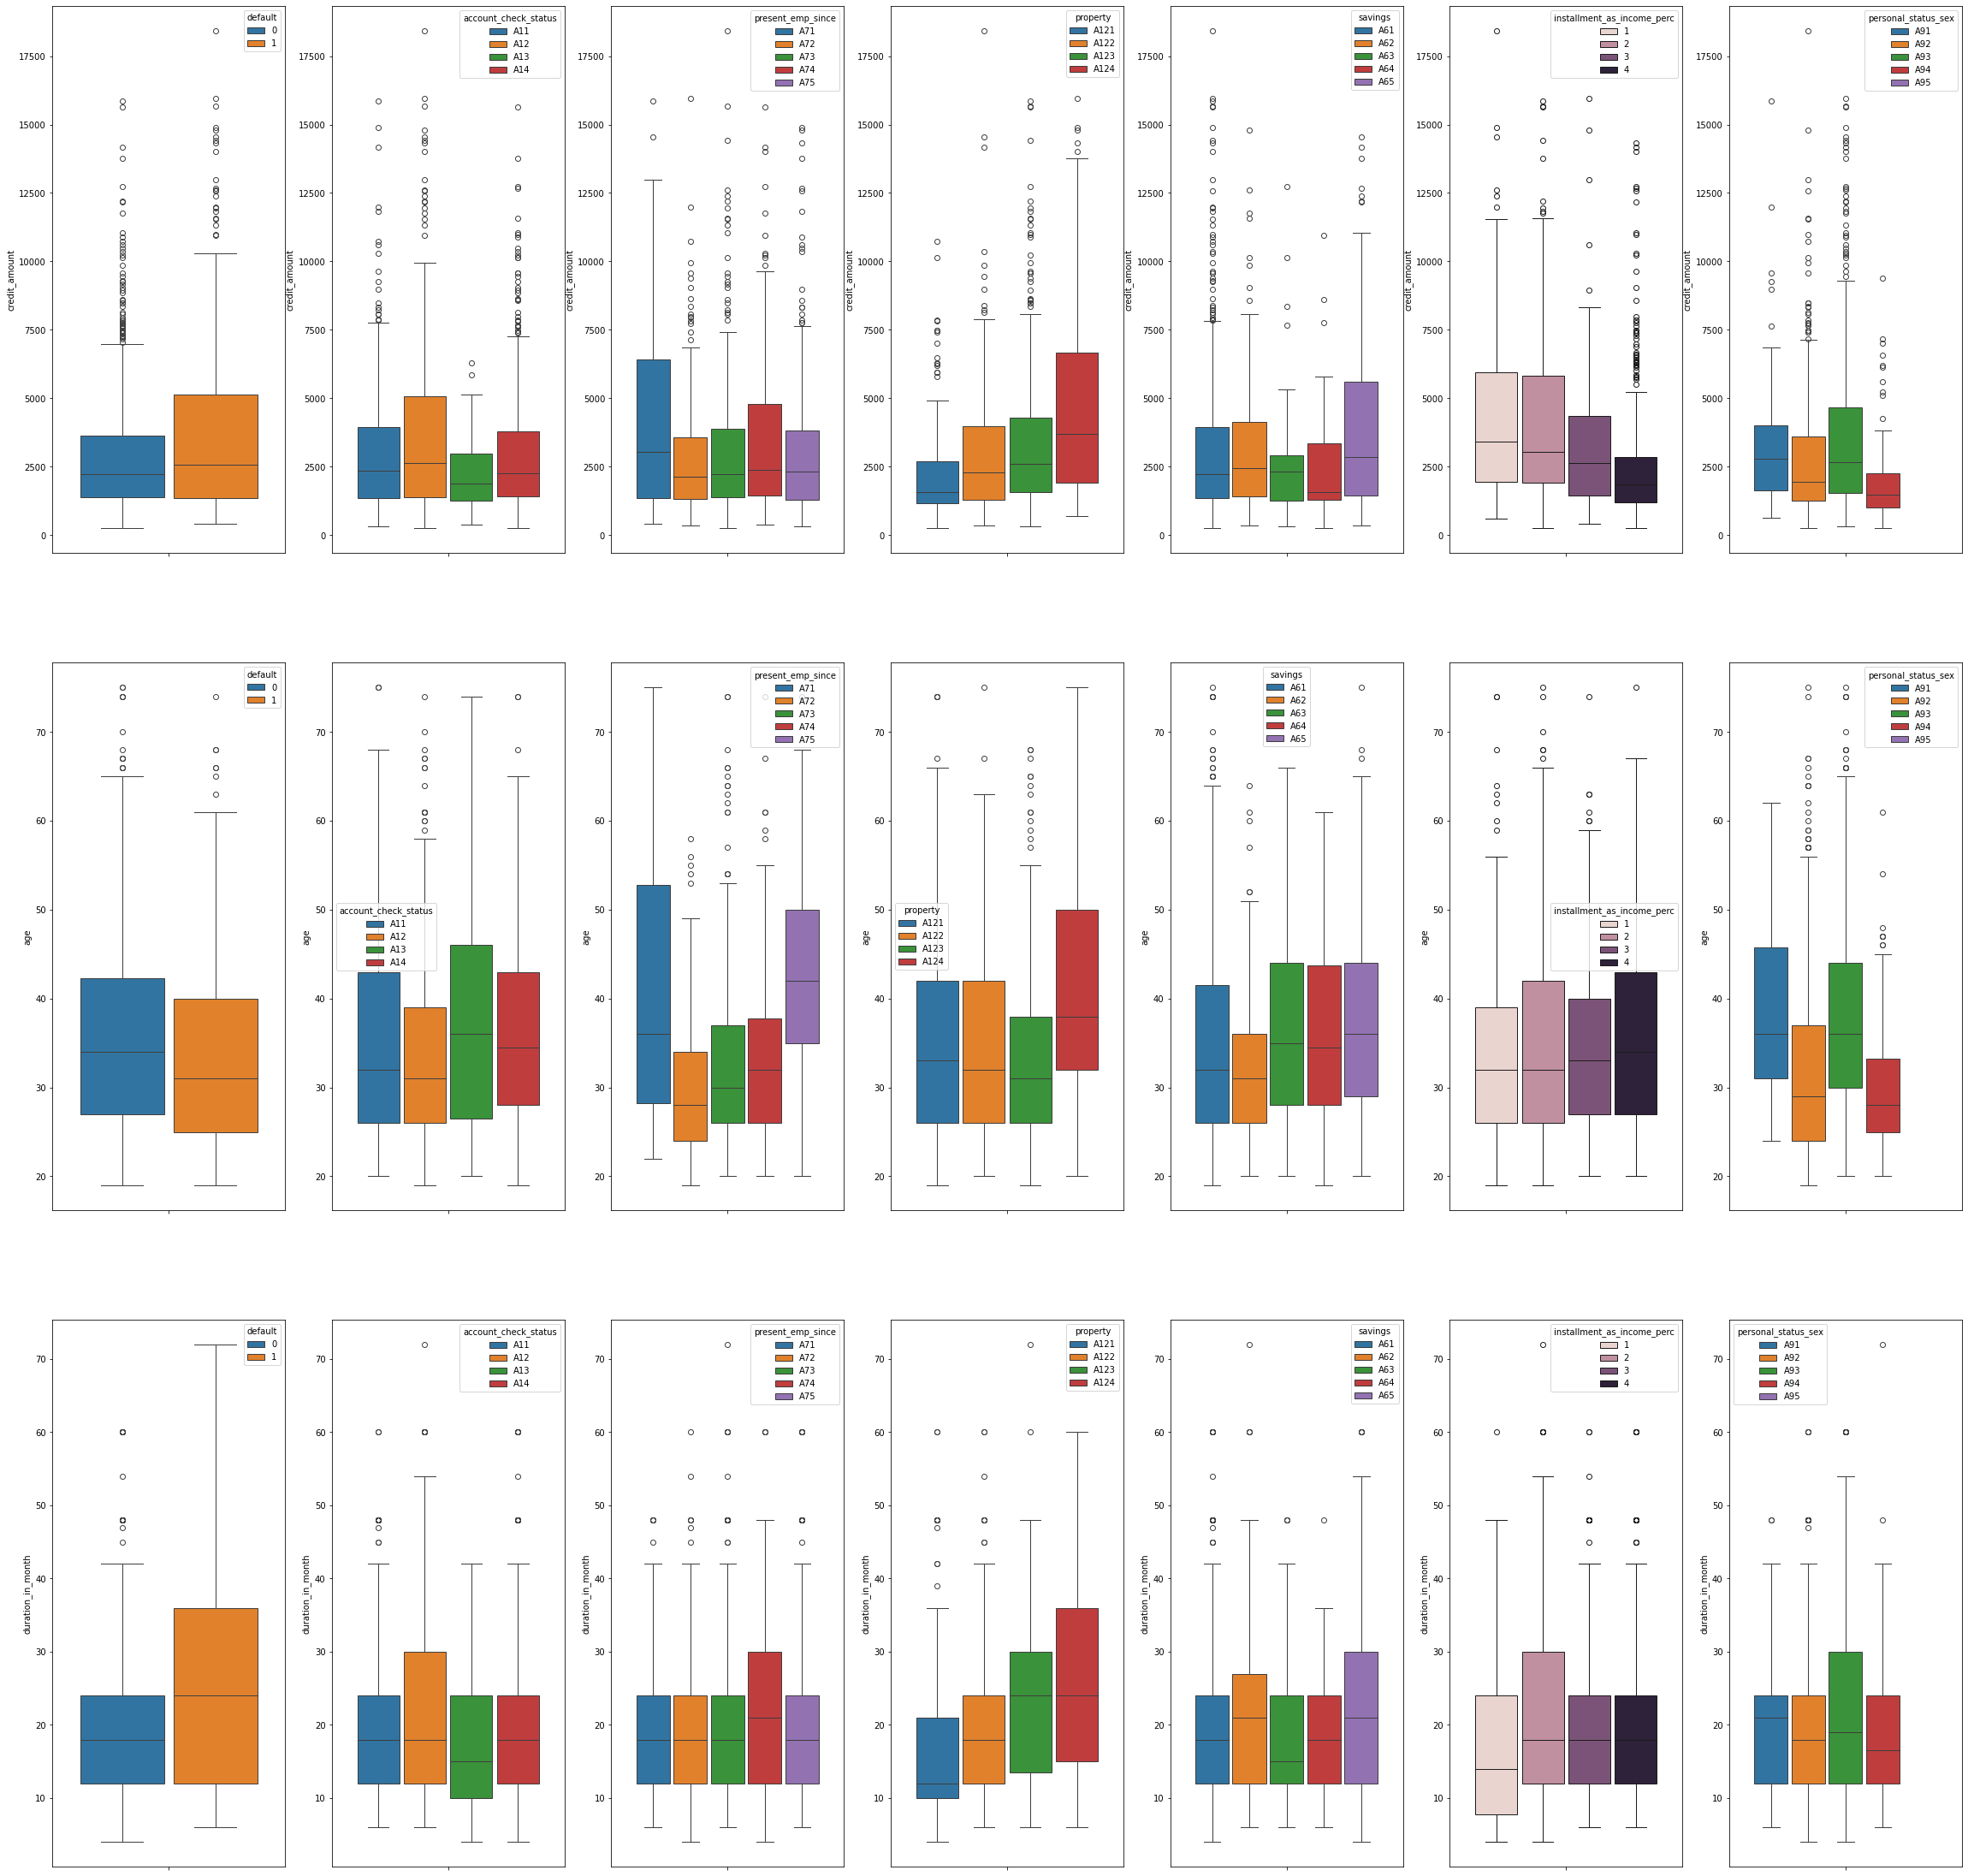

In [22]:
#Más visual
fig,axes = plt.subplots(3,7,figsize=(40,40))
hue_var = ['default','account_check_status','present_emp_since','property','savings','installment_as_income_perc','personal_status_sex']
n_var = ['credit_amount','age','duration_in_month']
for pos_x,var_x in enumerate(n_var):
    for pox_y,var_y in enumerate(hue_var):
        sns.boxplot(data=df,y=var_x,hue=var_y,gap=0.1, ax=axes[pos_x][pox_y])
plt.show()

## Descripción de las características de los datos

- **account_check_status**:
     - El 40% de los datos corresponde a clientes que no tienen cuenta corriente en el banco.
     - El 28% de los datos corresponde a clientes que están en números rojos en su cuenta corriente.
     - El 6% de los datos corresponde a clientes con más de 200 (¿mil?) marcos alemanes.
- **age**
    - Personas de entre 19 y 75 años en los datos.
    - Distribución muy escorada hacia la izquierda. Mediana: 33 años.
    - La mayor cantidad de personas se encuentra entre los 25 y los 31 años.
- **credit_amount**
    - La mayor parte de los créditos es por debajo de los 2500 DM. Mediana de 2319 DM.
    - Distribución muy escorada hacia la izquierda (créditos bajos)
- **credit_history**
    - Más del 50% de las personas tiene créditos pendientes que ha pagado debidamente hasta el momento.
    - Un 30% se consideran cuentas críticas.
    - Menos de 1% han pagado todos sus créditos debidamente dentro y fuera del banco.
    - Un 8% ha tenido retrasos en el pago de los créditos en el pasado.
    - Un 5% ha pagado todos sus créditos del banco debidamente.
- **credits_this_bank**
    - Todos tienen o han tenido al menos un crédito en el banco por lo que se dispone información de su historial crediticio.
    - La mayor parte tiene solo un crédito y más del 90% menos de 3.
- **default**
    - Más de 2/3 de los créditos no han sido concedidos
- **duration_in_month**
    - La duración del crédito más repetida es de entre 1 año y medio y 2 años.
    - Muy escorado hacia la izquierda. Créditos de corta duración. Mediana de un año y medio. Tercer cuartil 2 años.
- **foreign_worker**
    - La práctica totalidad de la información se corresponde con información de trabajadores extranjeros.
- **housing**
    - El 70% tiene una casa en propiedad (que puede estar o no pagando).
- **installment_as_income_perc**
    - Casi el 50% de los prestatarios gastan el 4% de su income en cuotas.
- **job**
    - La mayor parte de los prestatarios (63%) tienen un trabajo cualificado y fijo.
    - No existen apenas datos de prestatarios en situación de desempleo o sin formación.
- **other_debtors**
    - La mayor parte de los prestatarios (90%) afrontan el préstamo sin aval ni acompañante.
- **other_installment_plans**
    - Muy pocos tienen otras cuotas que pagar en bancos o tiendas.
- **people_under_maintenance**
    - Todos tienen a alguna persona bajo su manutención
    - El 85% de ellos solo tienen a una
- **personal_status_sex**
    - Más del 50% de los datos corresponde a hombres solteros
    - El 31% de los datos corresponde a mujeres no solteras
    - No hay datos para mujeres solteras
- **present_emp_since**
    - Más del 75% de los créditos pertenecen a prestatarios con trabajos de más de 1 año de duración
- **present_res_since**
    - Más del 50% lleva residiendo más de 3 años en el país.
- **property**
    - El 25% tienen una casa en propiedad.
    - Al menos más del 80% tienen un coche en propiedad o algo más valioso.
- **purpose**
    - La mayor parte de los créditos es concesión de créditos para coches, ya sean usados o nuevos.
    - O para pequeños electrodomésticos caseros.
    - Un 10% reseñable para negocios del prestatario.
- **savings**
    - La mayor parte tiene ahorros por debajo de los 100 (¿mil?) DM.
- **telephone**
    - Un 40% tienen teléfono.

### Resumen
Existe un sesgo entre los datos pues estos reflejan un perfil parecido al siguiente: hombre soltero o mujer NO soltera de mediana edad, extranjeros con cualificación trabajando más de un año y viviendo más de 2-3 años en el país pidiendo microcréditos de corta duración para consumo de electrodomésticos del hogar o coche. Tienen hipoteca y alguien bajo su cargo. Tienen al menos un coche en propiedad. Su historial crediticio es conocido y es calificado como malo o pendiente de ser valorado por crédito en marcha.

## Correlación o causalidad de las variables

- Existe una correlación positiva de 0.62 entre la duración del crédito y la cantidad concedida del mismo.
- La única correlación negativa algo reseñable es la que relaciona la cantidad de crédito concedida y las cuotas como porcentaje del income del prestatario.
- Hay una causalidad algo reseñable entre el historial crediticio del cliente y los créditos concedidos en el banco quizá causada por la mayor probabilidad de incurrir en problemas crediticios si se tienen muchos créditos.

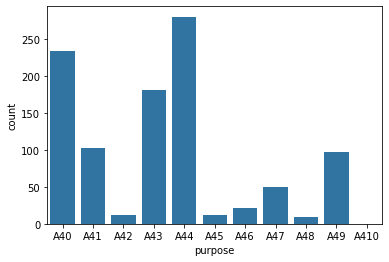

In [11]:
#Exploro más de cerca los countplots e histogramas
columna_a_explorar = 'purpose' #Cambie el valor a conveniencia y ejecute la celda
full_info.loc[full_info['column']==columna_a_explorar,'density_plots'].iloc[0].figure

In [12]:
percentage = True # Exploro la cantidad de valores como porcentaje del total
columna_a_explorar = 'telephone' #Variables categóricas
df[columna_a_explorar].value_counts(normalize=percentage)

A191    0.596
A192    0.404
Name: telephone, dtype: float64

## Outliers

Los outliers categóricos no existen sin un contexto del problema a resolver. Es evidente que hay un sesgo claro hacia un perfil específico de prestatario en los datos, pero este puede ser inducido por el contexto del estudio por el que se recogieron los datos. Aún así, sí que podemos detectar algunos patrones inusuales en los datos que ya hemos hecho notar en el análisis de las variables.

Sí podemos detectar outliers numéricos. Vamos a utilizar boxplots para ello.

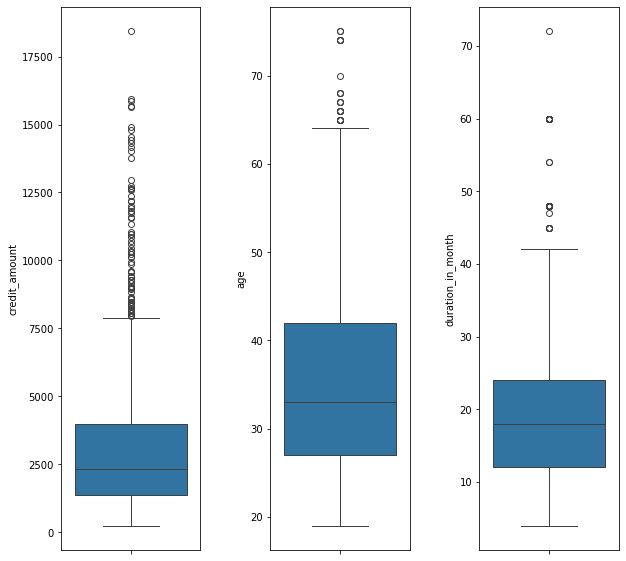

In [27]:
fig,axes = plt.subplots(1,3,figsize=(10,10))
for pos,var in enumerate(n_var):
    sns.boxplot(data=df,y=var,ax=axes[pos],gap=0)
plt.subplots_adjust(wspace=0.5)
plt.show()

## 1. Exploración teórica de clasificadores

In [28]:
# Fuente:
# http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [29]:
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

%matplotlib inline

In [30]:
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

def plot_classifiers(classifiers, datasets):
    
    figure = plt.figure(figsize=(4*6, 4*4))
    h = .02  # step size in the mesh
    i = 1
    # iterate over datasets
    for ds_cnt, ds in enumerate(datasets):
        # preprocess dataset, split into training and test part
        X, y = ds
        X = StandardScaler().fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=.4,
                                                            random_state=42)
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        
        # just plot the dataset first
        cm = plt.cm.RdBu
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        if ds_cnt == 0:
            ax.set_title("Input data", fontsize=24)
        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
                   edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        i += 1
        
        # iterate over classifiers
        for name, clf in classifiers:
            ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)
            
            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_min, y_max].
            if hasattr(clf, "decision_function"):
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            
            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
            
            # Plot also the training points
            ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                       edgecolors='k')
            # and testing points
            ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                       edgecolors='k', alpha=0.6)
            
            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())
            ax.set_xticks(())
            ax.set_yticks(())
            if ds_cnt == 0:
                ax.set_title(name, fontsize=24)
            ax.text(xx.max() - .3, yy.min() + .3, ('Score test: %.2f' % score).lstrip('0'),
                    size=15, horizontalalignment='right')
            i += 1
    
    plt.tight_layout()
    plt.show()

In [31]:
# data preparation
simple = make_blobs(n_samples=500, n_features=2,
                    centers=[[0,0], [2.5,2.5]],
                    random_state=1)
X,y = make_blobs(n_samples=500, n_features=2,
                 centers=[[0,0], [5,1]],
                 random_state=1)
X = X @ np.asarray([[1,-2],[-20,10]])
linearly_separable=(X,y)

datasets = [simple,
            linearly_separable,
            make_moons(noise=0.1, random_state=0, n_samples=500),
            make_circles(noise=0.1, factor=0.5, random_state=1,
                         n_samples=500)
           ]

C:\Users\guill\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\guill\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\guill\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\guill\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


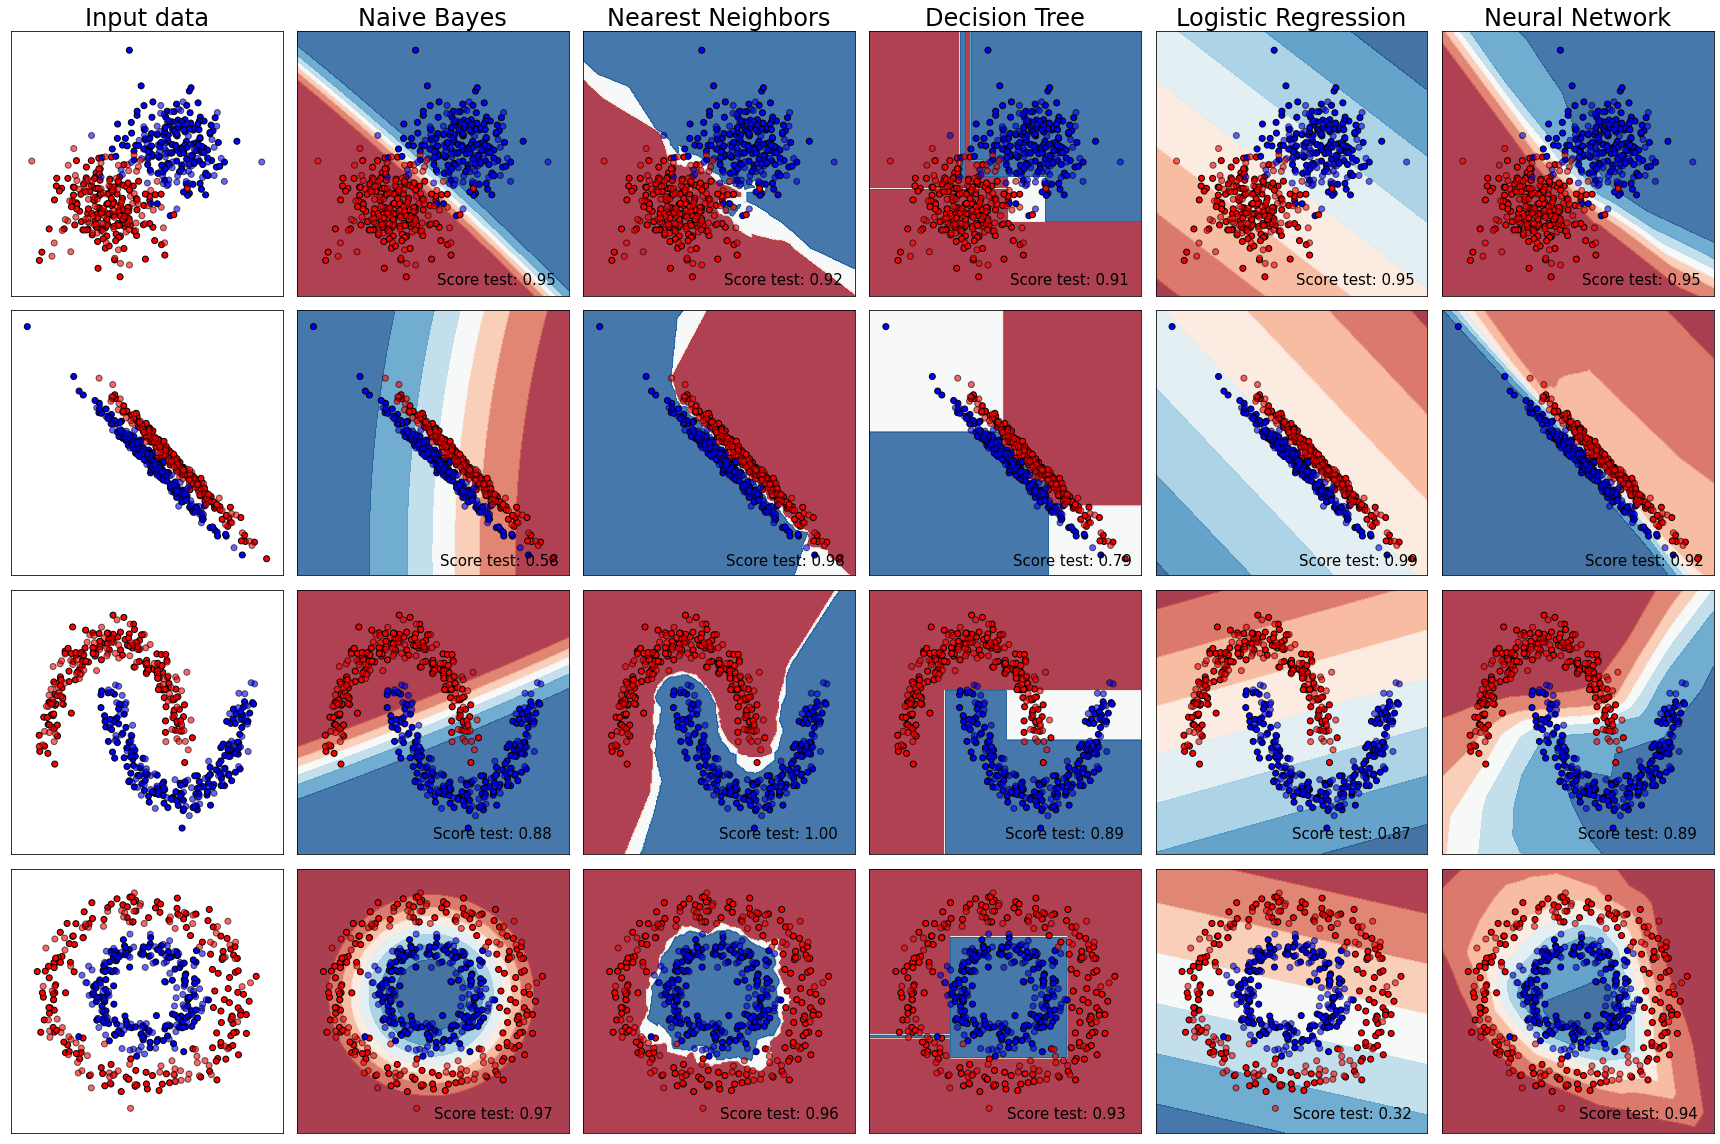

In [88]:
classifiers = [("Naive Bayes", GaussianNB()),
               ("Nearest Neighbors",
                KNeighborsClassifier(n_neighbors=2)), # número de vecinos
               ("Decision Tree",
                DecisionTreeClassifier(criterion='entropy',
                                       max_depth=4)), # profundidad máxima del árbol
               ("Logistic Regression",
                LogisticRegression(C=1.0e10, solver='lbfgs')), 
               # C: cuanto más alto menos regularización 
               ("Neural Network",
                MLPClassifier(hidden_layer_sizes=(10,10,10),
                              max_iter=100,
                              alpha=0.0))]

plot_classifiers(classifiers, datasets)

In [33]:
# Listado de los parámetros de los diferentes clasificadores
for name, clf in classifiers:
    print(clf)

GaussianNB()
KNeighborsClassifier(n_neighbors=1)
DecisionTreeClassifier(criterion='entropy', max_depth=2)
LogisticRegression(C=10000000000.0)
MLPClassifier(alpha=0.0, hidden_layer_sizes=(50,), max_iter=1000)


### Consideraciones técnicas sobre los algoritmos utilizados

* Número de vecinos en k-nn. 
    * ¿Debería ser impar cuando hay dos clases?
        * **Debería ser impar porque en el caso de que, por ejemplo, elijamos k=2 podría darse el caso de que los 2 vecinos más cercanos al punto sean de clases distintas por lo que _la clasificación del punto sería ambigua_** al haber un empate.
    * ¿Debería ser impar cuando hay más de dos clases?
        * **Sí. Para el caso de número de clases impares: si k fuese par, por ejemplo 2, se podría dar la situación de empate en puntos del plano cercanos a la frontera entre dos de las, por ejemplo, 3 clases y esto es algo que queremos evitar. Cualquier número impar no evitaría la situación de empate. Solo aquel que no sea divisor del número de clases. Para el número de clases pares mayores que dos, al igual que en el caso anterior, sería obligatorio el número de clases impares para evitar los casos de empate.**
* Profundidad máxima de los árboles de decisión.
    * Para profundidades pares menores o iguales que 6, en el conjunto de datos linealmente separables hay regiones del plano que se quedan sin clasificar con algunos datos dentro.
    * Para profundidades grandes, hay overfitting en los datos con unas fronteras de clasificación crecientemente complejas.
* Número de neuronas en la red neuronal y máximo número de épocas de entrenamiento.
    * Con 1000 iteraciones:
        * Para make_blobs añadir profundidad no tiene efecto sobre el score (siempre es 0.94 o 0.95) hasta alcanzar el nivel de los 0.98-1.00 como sí lo hacen los otros datasets.
        * Para make_blobs, el número de capas hace que la frontera de clasificación cambie su convexidad:
            * Si el número de capas es par, es de curvatura cóncava.
            * Si el número de capas es impar, es de curvatura convexa.
            * Si el número de capas aumenta, la curvatura tiende a ser 0 (recta).
        * Para los otros datasets:
        * Con (50,):
            * Obtenemos un score de 0.99 para make circles y linearly_separable
            * Obtenemos un score de 0.98 para make moons
        * Con (50,10):
            * Obtenemos un perfect score para make moons
            * Obtenemos un score de 0.99 para linearly separable y make circles
        * Con (50,10,20):
            * La score de make_circles empeora a 0.98. Si escogemos un número mayor que 20 la score de make_circles puede empeorar, aunque las fronteras de clasificación se ajusten más la una a la otra.
        * Con (10,10,10):
            * Se obtienen unas scores muy similares a las de (50,10,20)
        * Con (10,10,10,50):
            * Make_circles alcanza su mejor score de 0.99
    * Aumentar el número de iteraciones:
        * No tiene efectos perceptibles sobre las fronteras de clasificación para (50,)
        * Empeora el score de 0.99 a 0.98 para make_circles con (10,10,10,50)
        * No aumenta el score de make_blobs en ningún caso por encima del 0.95
    * Disminuir el número de iteraciones:
        * Make_moons es el dataset que más susceptible es a empeorar ante los cambios en el número de iteraciones, aunque estos cambios no sean excesivos. El número de capas y sus neuronas afecta a la forma de su frontera. Una configuración de muchas capas y neuronas consiguen una frontera picuda, mientas que si se baja el número de neuronas o sus capas se convierte una frontera más sinuosa que se ajusta peor a la zona que separa los dos conjuntos de datos.
        * Un bajo número de iteraciones (100) hace que el score de make_circles empeore hasta los 0.72 para (10,10)
        * Linearly_separable se mantiene en el rango por encima de 0.97 para pocas iteraciones para (10,10).
        * Make_bloobs mantiene su score por encima de 0.93 para (10,) y pocas iteraciones. El resto, en este caso, empeoran mucho su score. Es decir, **make_bloobs** es el dataset que peor rango de mejora tiene para una red neuronal a la vez que es el dataset que mejor rango de empeoramiento tiene. Se podría decir que, **según lo observado, las redes neuronales performean peor en conjuntos de datos con ruido que interfiera con la región de separación entre clases**.
        * Linearly_separable es más sensible al número de neuronas en una única capa cuando se trata de pocas iteraciones:
            * Score de 0.59 con (10,)
            * Score de 0.93 con (50,)

## 2. Construcción de un clasificador sobre los datos de german_credit_data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [2]:
df_o = pd.read_csv('./data/german_credit_data.csv', sep=';')
# Source: https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)
# This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix

print(df_o.shape)
df_o.head(5)

(1000, 21)


,default,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,...,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
0,0,< 0 DM,6,critical account/ other credits existing (not ...,domestic appliances,1169,unknown/ no savings account,.. >= 7 years,4,male : single,...,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes
1,1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,...,2,real estate,22,none,own,1,skilled employee / official,1,none,yes
2,0,no checking account,12,critical account/ other credits existing (not ...,(vacation - does not exist?),2096,... < 100 DM,4 <= ... < 7 years,2,male : single,...,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,0,< 0 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,...,4,if not A121 : building society savings agreeme...,45,none,for free,1,skilled employee / official,2,none,yes
4,1,< 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,...,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes


In [3]:
class_label = 'default'
feature_names = list(df_o.columns)
feature_names.remove(class_label)
print(feature_names)
X = df_o[feature_names].values
y = df_o[class_label].values

['account_check_status ', 'duration_in_month ', 'credit_history ', 'purpose ', 'credit_amount ', 'savings ', 'present_emp_since ', 'installment_as_income_perc ', 'personal_status_sex ', 'other_debtors ', 'present_res_since ', 'property ', 'age ', 'other_installment_plans ', 'housing ', 'credits_this_bank ', 'job ', 'people_under_maintenance ', 'telephone ', 'foreign_worker']


**Estadísticos básicos de cada atributo:**

In [4]:
df_o.describe()

,default,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.300000,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,0.458487,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,0.000000,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,0.000000,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,0.000000,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,1.000000,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,1.000000,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


**Datos codificados de forma numérica**

In [5]:
df = pd.read_csv('./data/german_credit_data_numeric.csv', sep=';')
class_label = 'Class'
feature_names = list(df.columns)
feature_names.remove(class_label)
print(feature_names)
X = df[feature_names].values
y = df[class_label].values

['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23']


**Histogramas suavizados de cada atributo en cada clase. El color indica la clase ("default"/"no default"):**

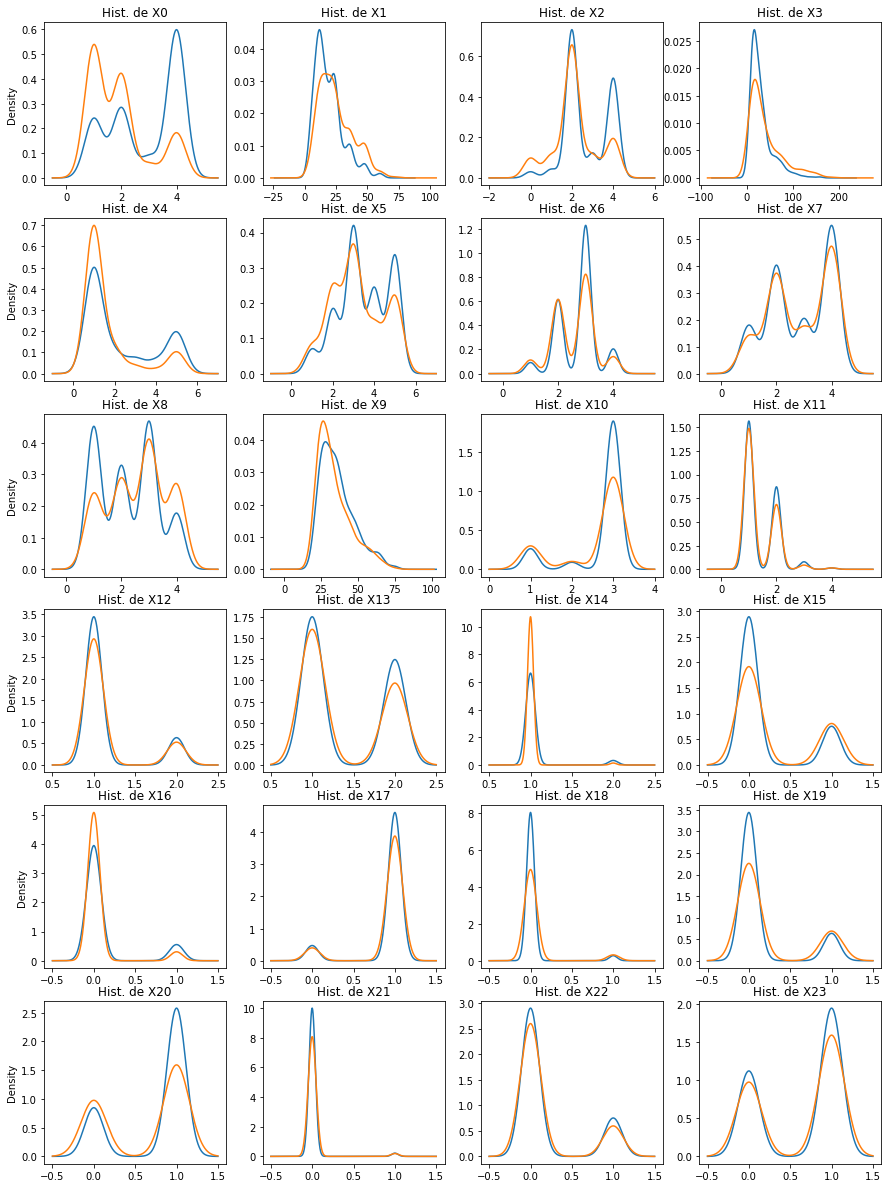

In [6]:
plt.figure(figsize=(15, 21))
n_cols_plot = 4
n_rows_plot = int(len(feature_names) / n_cols_plot)
for i,n in enumerate(feature_names):
    plt.subplot(n_rows_plot, n_cols_plot, i+1)
    aux = 'Density' if i%n_cols_plot == 0 else ''
    df.groupby('Class')[n].plot(kind='kde', title='Hist. de '+n)
    plt.ylabel(aux)

## Entrenamiento de un modelo y chequeo de su calidad usando 5-fold cross validation

La siguiente celda entrena un modelo y lo evalúa en varias particiones training-test diferentes de los datos. El resultado es un score medio junto a su desviación estándar. El tipo de modelo (Naïve Bayes / árbol de decisión / knn/ regresión logística / red neuronal) y parámetros empleados deberán ser seleccionados para que dicho resultado sea el mejor posible.

In [7]:
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import numpy as np
# otros clasificadores (del notebook p4_01)

nn = MLPClassifier(hidden_layer_sizes=(10,10,10),
                              max_iter=100,
                              alpha=0.0)
lr = LogisticRegression(C=1.0e10, solver='lbfgs')
tree = DecisionTreeClassifier(criterion = 'entropy', max_depth=3)
nv = GaussianNB()
neighbors = KNeighborsClassifier(n_neighbors=1)
clf = neighbors
def score (clf):
    return cross_val_score(clf, X, y, cv=10) # 10-fold cross-validation
scores = score(clf)
print('Precisión en cada una de las particiones: ', scores)
print('Estimación de la precisión por validación cruzada: {:.2f} +/- {:.2f}'.format(scores.mean(), scores.std()))

Precisión en cada una de las particiones:  [0.67 0.64 0.72 0.66 0.64 0.71 0.6  0.71 0.62 0.66]
Estimación de la precisión por validación cruzada: 0.66 +/- 0.04


In [8]:
(y==1).sum(),(y==2).sum()

(700, 300)

## k-nearest neighbors

* Para un número bajo de vecinos.
    * Al escoger pocos vecinos con los que comparar estamos heterogeneizando demasiado el conjunto de datos pues un dato será similar a los demás con menos facilidad. Es decir, estamos sobreajustando el modelo.

* Para un número alto de vecinos.
    * Un gran conjunto de datos deben parecerse mucho entre sí para ser considerados de la misma clase, es decir, estamos considerando grandes grupos de datos perteneciendo a una misma categoría, es decir, estamos haciendo pocos subconjuntos del conjunto de datos lo que puede no estar capturando las particularidades de los mismos. Es decir, estamos subajustando.

* Para el mayor valor posible de k. k=899.
    * Al incrementar el número de vecinos disminuye la probabilidad de clasificar mal el punto pues el peso relativo de cada vecino perteneciente a cada clase errónea disminuye. Partiendo de la hipótesis de que la clasificación correcta del punto es la de la clase más frecuente cerca del mismo, esto favorece, por tanto, que el punto sea clasificado con la clase de mayor frecuencia absoluta cerca del mismo.
    * La cross-validation fold con cv=10 parte el conjunto de 1000 datos en 10 subconjuntos de 100 datos. Entrena un modelo descartando uno de los diez subconjuntos, es decir, con 9 subconjuntos: 900 datos. Una vez entrenado el modelo, lo valida con el conjunto de 100 datos descartados sacando un score. Repite el proceso descartando en cada iteración uno subconjunto distinto.
    * Al hacer la validación sobre un conjunto de 900 elementos con cross-fold-validation, el mayor número de vecinos a escoger será el del conjunto de validación menos el del punto a evaluar, es decir, 899.
    * Al hacer la validación sobre un número impar de vecinos no hay posibilidad de empate por lo que todos los puntos serán clasificados en el conjunto de mayor cardinal.
    * Adaptando esta lógica para nuestro conjunto de datos: hay dos clases. Una de cardinal 700 y otra de cardinal 300. Por tanto, para un conjunto de cardinal 900 habrá, en el mejor de los casos para la clase minoritaria, 300 puntos para la clase minoritaria y 600 puntos de la otra. Si k>600 entonces todo punto del conjunto de 900 será clasificado como punto de la clase mayoritaria. Los 100 puntos retirados son de la clase mayoritaria por lo que al hacer la cross-validation con ese fold saldrá una score de 1.
    * Para el peor de los casos para la clase minoritaria, (200,700) con k>400 se clasificarían todos los puntos como de la clase mayoritaria, pero al validarlos saldría score 0.
    * Aplicando esta lógica a lo largo de los 10 conjuntos de validación, 3 con todos sus puntos de clase minoritaria y 7 de la mayoritaria, con k > 600 nos saldría que la media de las 10 cross-validation sería 7/10 = 0.7 que es justo el valor al que tiende la score conforme k aumenta de valor. De hecho, este valor de la score se asienta con k~120.

* Para k~120
    * Conseguimos estabilizar la media de los score en 0.7 con desviación típica 0, es decir, hemos entrenado 10 modelos que clasifican bien en todo caso el 70% de los puntos a lo largo de cada subconjunto descartado utilizando como datos de entrenamiento los restantes 900 datos.

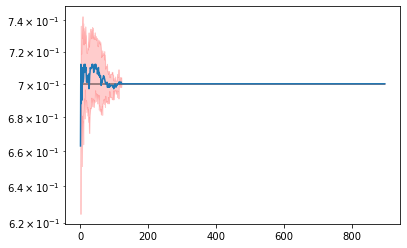

In [9]:
a = []
b = []
error = []
for j in range(1,899):
    a += [j]
    clf = score(KNeighborsClassifier(n_neighbors=j))
    b += [clf.mean()]
    error += [clf.std()]

b = np.array(b)
error = np.array(error)
plt.hlines(b[-1],a[0],a[-1],colors='k',alpha=0.5)
plt.semilogy(a,b)
plt.fill_between(a, b - error, b + error, color='red', alpha=0.2)

In [10]:
#Mejor precisión
for pos,s in enumerate(b):
    if s == max(b):
        max_pos = pos
print(f'Profundidad con mejor score: {max_pos+1}.\nMejor score: {max(b)}\nCon desviación típica: {error[max_pos]}\nQue es un {round((1-error[:120].mean()/max(error))*100,2)}% más pequeña que la media de las desviaciones típicas.')

Profundidad con mejor score: 46.
Mejor score: 0.712
Con desviación típica: 0.017776388834631195
Que es un 59.94% más pequeña que la media de las desviaciones típicas.


## Decision tree

La mayor profundidad del árbol es aquella que hace que cada dato sea una hoja del árbol (perfect-fit). Sin embargo, un árbol con una profundidad excesiva hace que el poder de generalización del modelo sea muy malo, tal y como demuestra la gráfica:
* Para valores muy altos de profundidad, hay un peor score y un mayor rango de posibles scores alrededor de la media.
* Para max_depth = 3 se alcanza la mejor score pues el árbol es capaz de generalizar lo suficiente como para poder clasificar datos que no conoce (los del conjunto de validación).

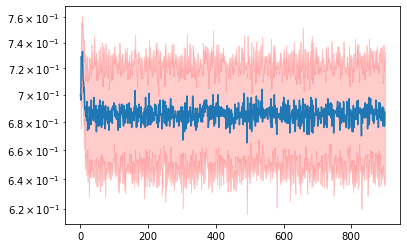

In [11]:
a = []
b = []
error = []
for j in range(1,900):
    a += [j]
    clf = score(DecisionTreeClassifier(criterion = 'entropy', max_depth=j))
    b += [clf.mean()]
    error += [clf.std()]

b = np.array(b)
error = np.array(error)
#plt.hlines(b[-1],a[0],a[-1],colors='k',alpha=0.5)
plt.semilogy(a,b)
plt.fill_between(a, b - error, b + error, color='red', alpha=0.2)

In [12]:
#Mejor precisión
for pos,s in enumerate(b):
    if s == max(b):
        max_pos = pos
print(f'Profundidad con mejor score: {max_pos+1}.\nMejor score: {max(b)}\nCon desviación típica: {error[max_pos]}\nQue es un {round((1-error.mean()/max(error))*100,2)}% más pequeña que la media de las desviaciones típicas.')

Profundidad con mejor score: 7.
Mejor score: 0.733
Con desviación típica: 0.02051828452868321
Que es un 32.08% más pequeña que la media de las desviaciones típicas.


# Neural networks

En ambos casos (1 y 2 capas ocultas) la mejor precisión alcanzada es 0.79. La progresión en la mejora del score es rápida al inicio del incremento de capas, pero después disminuye su velocidad y pasa a ser de crecimiento logarítmico. Añadir una capa más no ha mejorado el score para este problema en específico. Se ha escogido dar a la primera capa un valor constante igual al número de neuronas que mejor perfomearon en la primera capa.

  0%|          | 0/49 [00:00<?, ?it/s]

C:\Users\guill\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


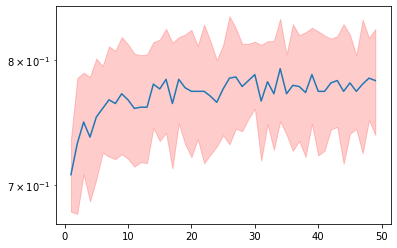

In [13]:
from tqdm.notebook import tqdm
a = []
b_nn = []
error_nn = []
for j in tqdm(range(1,50)):
    a += [j]
    clf = score(MLPClassifier(hidden_layer_sizes=(j,),
                              max_iter=1000,
                              alpha=0.0))
    b_nn += [clf.mean()]
    error_nn += [clf.std()]

b_nn = np.array(b_nn)
error_nn = np.array(error_nn)
#plt.hlines(b[-1],a[0],a[-1],colors='k',alpha=0.5)
plt.semilogy(a,b_nn)
plt.fill_between(a, b_nn - error_nn, b_nn + error_nn, color='red', alpha=0.2)

In [14]:
#Mejor precisión
for pos,s in enumerate(b_nn):
    if s == max(b_nn):
        max_pos = pos
print(f'Número de neuronas con mejor score: {max_pos+1}.\nMejor score: {max(b_nn)}\nCon desviación típica: {error_nn[max_pos]}\nQue es un {round((1-error_nn.mean()/max(error_nn))*100,2)}% más pequeña que la media de las desviaciones típicas.')

Número de neuronas con mejor score: 34.
Mejor score: 0.7929999999999999
Con desviación típica: 0.04337049688440288
Que es un 25.11% más pequeña que la media de las desviaciones típicas.


  0%|          | 0/49 [00:00<?, ?it/s]

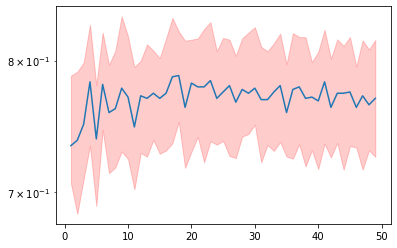

In [15]:
from tqdm.notebook import tqdm
a = []
b_nn_2 = []
error_nn_2 = []
for j in tqdm(range(1,50)):
    a += [j]
    clf = score(MLPClassifier(hidden_layer_sizes=(37,j),
                              max_iter=1000,
                              alpha=0.0))
    b_nn_2 += [clf.mean()]
    error_nn_2 += [clf.std()]

b_nn_2 = np.array(b_nn_2)
error_nn_2 = np.array(error_nn_2)
plt.semilogy(a,b_nn_2)
plt.fill_between(a, b_nn_2 - error_nn, b_nn_2 + error_nn_2, color='red', alpha=0.2)

In [16]:
#Mejor precisión
for pos,s in enumerate(b_nn_2):
    if s == max(b_nn_2):
        max_pos = pos
print(f'Capas y neuronas con mejor score: (37,{max_pos+1}).\nMejor score: {max(b_nn_2)}\nCon desviación típica: {error_nn_2[max_pos]}\nQue es un {round((1-error_nn_2.mean()/max(error_nn_2))*100,2)}% más pequeña que la media de las desviaciones típicas.')

Capas y neuronas con mejor score: (37,18).
Mejor score: 0.788
Con desviación típica: 0.036
Que es un 27.67% más pequeña que la media de las desviaciones típicas.


## Tabla

| | k-nearest_neighbors | tree | nn_1_hidden | nn_2_hidden (max(nn_1_hidden.score.n_neurons), _) |
|-----------|-----------|-----------|-----------|-----------|
| Best conf | 46 | 7 | (37,) | (37,45) |
| Best score (with best conf) | 0.712 | 0.729 | 0.79| 0.79 |
| Std dv of best score | 0.0177 | 0.02426 | 0.0467 | 0.0429 |
| % más pequeño con respecto a la media de la std_dev | 59.94% | 27.67% | 29.71% | 32.42% |

## ¿Cómo se determina el valor de los hiperparámetros?

Para determinar el valor de los hiperparámetros de un modelo realizaremos una búsqueda en una rejilla. De entre los valores considerados seleccionaremos los que maximicen la estimación por validación cruzada (K = 10) de la tasa de acierto.

In [17]:
import pandas as pd


def print_dataframe(filtered_cv_results):
    """Pretty print for filtered dataframe"""
    for mean_precision, std_precision, mean_recall, std_recall, params in zip(
        filtered_cv_results["mean_test_precision"],
        filtered_cv_results["std_test_precision"],
        filtered_cv_results["mean_test_recall"],
        filtered_cv_results["std_test_recall"],
        filtered_cv_results["params"],
    ):
        print(
            f"precision: {mean_precision:0.3f} (±{std_precision:0.03f}),"
            f" recall: {mean_recall:0.3f} (±{std_recall:0.03f}),"
            f" for {params}"
        )
    print()


def refit_strategy(cv_results):
    """Define the strategy to select the best estimator.

    The strategy defined here is to filter-out all results below a precision threshold
    of 0.98, rank the remaining by recall and keep all models with one standard
    deviation of the best by recall. Once these models are selected, we can select the
    fastest model to predict.

    Parameters
    ----------
    cv_results : dict of numpy (masked) ndarrays
        CV results as returned by the `GridSearchCV`.

    Returns
    -------
    best_index : int
        The index of the best estimator as it appears in `cv_results`.
    """
    # print the info about the grid-search for the different scores
    precision_threshold = 0.7

    cv_results_ = pd.DataFrame(cv_results)
    print("All grid-search results:")
    print_dataframe(cv_results_)

    # Filter-out all results below the threshold
    high_precision_cv_results = cv_results_[
        cv_results_["mean_test_precision"] > precision_threshold
    ]

    print(f"Models with a precision higher than {precision_threshold}:")
    print_dataframe(high_precision_cv_results)

    high_precision_cv_results = high_precision_cv_results[
        [
            "mean_score_time",
            "mean_test_recall",
            "std_test_recall",
            "mean_test_precision",
            "std_test_precision",
            "rank_test_recall",
            "rank_test_precision",
            "params",
        ]
    ]

    # Select the most performant models in terms of recall
    # (within 1 sigma from the best)
    best_recall_std = high_precision_cv_results["mean_test_recall"].std()
    best_recall = high_precision_cv_results["mean_test_recall"].max()
    best_recall_threshold = best_recall - best_recall_std

    high_recall_cv_results = high_precision_cv_results[
        high_precision_cv_results["mean_test_recall"] > best_recall_threshold
    ]
    print(
        "Out of the previously selected high precision models, we keep all the\n"
        "the models within one standard deviation of the highest recall model:"
    )
    print_dataframe(high_recall_cv_results)
    print(cv_results["params"])

    # From the best candidates, select the fastest model to predict
    fastest_top_recall_high_precision_index = high_recall_cv_results[
        "mean_score_time"
    ].idxmin()

    print(
        "\nThe selected final model is the fastest to predict out of the previously\n"
        "selected subset of best models based on precision and recall.\n"
        "Its scoring time is:\n\n"
        f"{high_recall_cv_results.loc[fastest_top_recall_high_precision_index]}"
    )

    return fastest_top_recall_high_precision_index

In [18]:
# DecisionTreeClassifier()
from sklearn.model_selection import GridSearchCV

scores = ["precision", "recall"]
tuned_parameters_tree = [
    {"max_depth": [3,4,5], "min_samples_split": np.arange(40,90,10), "max_features": [7,8,9],\
     "min_samples_leaf":np.arange(190,202,2)}
]

grid_search = GridSearchCV(
    DecisionTreeClassifier() , tuned_parameters_tree, scoring=scores, refit=refit_strategy
)
grid_search.fit(X, y)

All grid-search results:
precision: 0.700 (±0.000), recall: 1.000 (±0.000), for {'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 190, 'min_samples_split': 40}
precision: 0.700 (±0.000), recall: 1.000 (±0.000), for {'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 190, 'min_samples_split': 50}
precision: 0.700 (±0.000), recall: 1.000 (±0.000), for {'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 190, 'min_samples_split': 60}
precision: 0.718 (±0.036), recall: 0.966 (±0.069), for {'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 190, 'min_samples_split': 70}
precision: 0.700 (±0.000), recall: 1.000 (±0.000), for {'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 190, 'min_samples_split': 80}
precision: 0.715 (±0.030), recall: 0.967 (±0.066), for {'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 192, 'min_samples_split': 40}
precision: 0.700 (±0.000), recall: 1.000 (±0.000), for {'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 192, 'min_samples_

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': [3, 4, 5], 'max_features': [7, 8, 9],
                          'min_samples_leaf': array([190, 192, 194, 196, 198, 200]),
                          'min_samples_split': array([40, 50, 60, 70, 80])}],
             refit=<function refit_strategy at 0x000001DC5E32B040>,
             scoring=['precision', 'recall'])

In [70]:
# KNeighborsClassifier()
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

scores = ["precision", "recall"]
tuned_parameters_tree = [
    {"weights": ["uniform","distance"], "p": np.arange(1,5,1), "n_neighbors": np.arange(3,52,2)}
]

grid_search = GridSearchCV(
    KNeighborsClassifier() , tuned_parameters_tree, scoring=scores, refit=refit_strategy
)
grid_search.fit(X, y)

All grid-search results:
precision: 0.823 (±0.012), recall: 0.911 (±0.024), for {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
precision: 0.829 (±0.013), recall: 0.914 (±0.022), for {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
precision: 0.779 (±0.015), recall: 0.868 (±0.032), for {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
precision: 0.782 (±0.017), recall: 0.871 (±0.033), for {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
precision: 0.767 (±0.018), recall: 0.856 (±0.024), for {'n_neighbors': 3, 'p': 3, 'weights': 'uniform'}
precision: 0.767 (±0.018), recall: 0.859 (±0.022), for {'n_neighbors': 3, 'p': 3, 'weights': 'distance'}
precision: 0.765 (±0.018), recall: 0.853 (±0.020), for {'n_neighbors': 3, 'p': 4, 'weights': 'uniform'}
precision: 0.766 (±0.018), recall: 0.856 (±0.019), for {'n_neighbors': 3, 'p': 4, 'weights': 'distance'}
precision: 0.819 (±0.019), recall: 0.929 (±0.016), for {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
precision: 0.826 (±0.019), recall: 

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39, 41, 43, 45, 47, 49, 51]),
                          'p': array([1, 2, 3, 4]),
                          'weights': ['uniform', 'distance']}],
             refit=<function refit_strategy at 0x000001DC5E32B040>,
             scoring=['precision', 'recall'])

## Procesamiento de datos para la mejora del perform de los clasificadores

In [20]:
outliers_in_col = {}
for col in df.columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    outliers = (df[col] < q1 - 1.5 * iqr) | (df[col] > q3 + 1.5 * iqr)
    outliers_in_col[col] = {}
    outliers_in_col[col]['iqr'] = iqr
    outliers_in_col[col]['n_outliers'] = outliers.sum()
    outliers_in_col[col]['outliers'] = outliers
    
u = np.zeros(1000)
for outlier in outliers_in_col.values():
    u += outlier['outliers']

#Quito aquellos registros que tengan un número inusual de outliers en cada uno de sus campos
q1u = u.quantile(0.25)
q3u = u.quantile(0.75)
iqru = q3u - q1u
mask = (u > q1u - 1.5*iqru)&(u < q3u + 1.5*iqru)
df_no_outliers = df[mask]
df_no_outliers

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Class
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,1
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,1
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4,12,2,17,1,4,2,4,1,31,...,0,0,1,0,0,1,0,1,0,1
996,1,30,2,39,1,3,1,4,2,40,...,0,1,1,0,0,1,0,0,0,1
997,4,12,2,8,1,5,3,4,3,38,...,0,0,1,0,0,1,0,0,1,1
998,1,45,2,18,1,3,3,4,4,23,...,0,0,1,0,0,0,0,0,1,2


In [21]:
df_no_label = df_no_outliers.iloc[:,:-1]
df_no_label

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
0,1,6,4,12,5,5,3,4,1,67,...,1,0,0,1,0,0,1,0,0,1
1,2,48,2,60,1,3,2,2,1,22,...,1,0,0,1,0,0,1,0,0,1
2,4,12,4,21,1,4,3,3,1,49,...,1,0,0,1,0,0,1,0,1,0
3,1,42,2,79,1,4,3,4,2,45,...,1,0,0,0,0,0,0,0,0,1
4,1,24,3,49,1,3,3,4,4,53,...,1,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4,12,2,17,1,4,2,4,1,31,...,1,0,0,1,0,0,1,0,1,0
996,1,30,2,39,1,3,1,4,2,40,...,1,0,1,1,0,0,1,0,0,0
997,4,12,2,8,1,5,3,4,3,38,...,1,0,0,1,0,0,1,0,0,1
998,1,45,2,18,1,3,3,4,4,23,...,1,0,0,1,0,0,0,0,0,1


<AxesSubplot:>

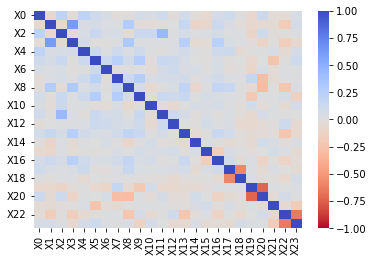

In [22]:
import seaborn as sns
sns.heatmap(df_no_label.corr(),vmax=1,vmin=-1,cmap='coolwarm_r')

### Análisis de componentes principales (PCA . Principal component analysis)
Fuente: https://ichi.pro/es/la-maldicion-de-la-dimensionalidad-24160548231634

Una gran dimensionalidad de los datos puede llevar al fenómeno de Hughes:

"A medida que aumenta la dimensionalidad, el rendimiento del clasificador aumenta hasta alcanzar el número óptimo de características. Observamos que aumentar aún más la dimensionalidad **sin aumentar el número de muestras de entrenamiento** da como resultado una disminución en el rendimiento del clasificador."

Dado que nuestro dataset es de alta dimensionalidad (23) y de pocos datos (1000) he decidido lanzarme a utilizar una técnica de reducción de la dimensionalidad denominada PCA.

PCA es sensible a outliers, de ahí la eliminación que hemos hecho de los mismos.

In [23]:
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

df_no_label.var(axis=1)

0      181.913043
1      237.201087
2      110.476449
3      372.260870
4      210.519928
          ...    
995     49.797101
996    144.688406
997     61.326087
998    104.804348
999    175.362319
Length: 945, dtype: float64

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-0.013598,2.895281,-0.673495,1.892780,-0.445328,-0.026558,0.325067,1.324058,-0.316180,-0.393942,...,2.467575,0.986846,-0.951668,0.702046,0.969641,-0.300295,-0.497835,0.315609,-0.167887,-0.036183
1,0.181226,-1.184253,1.982477,-1.519894,-0.195599,-0.288467,-0.291785,-0.765745,-0.174802,-1.528582,...,0.867644,-0.268775,0.877914,-0.047146,-0.424983,-0.451612,-0.282264,-0.533849,0.097376,0.427338
2,-2.037560,1.999939,-2.103333,-0.221444,0.829540,-0.321168,-1.069601,-0.458941,0.722985,-0.137652,...,0.139132,-1.338032,0.733001,-0.122247,0.120591,-1.434241,-0.381279,0.259386,-0.165734,-0.055209
3,1.464522,-0.940580,0.688530,1.070210,3.266492,-1.074213,0.693417,-0.271622,1.619554,-0.532409,...,1.519129,-0.991466,0.785794,-0.147523,0.491857,-0.802696,2.236418,0.911806,0.010783,0.952984
4,1.537678,0.392718,-1.392326,0.809777,1.014075,-0.651736,3.311525,-0.865428,0.673155,-0.270234,...,-0.617926,-0.109123,0.096723,-0.471308,1.502861,-0.078605,0.075905,0.188416,-0.178011,0.498837


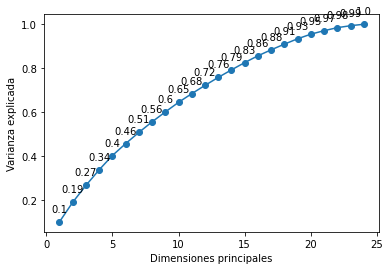

In [24]:
# Análisis de componentes principales para la reducción de la dimensionalidad
# Fuente: Machine Learning Aplicado Usando Python. Editorial: Ideas Propias

pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(df_no_label)
modelo_pca = pca_pipe.named_steps['pca']
modelo_pca.explained_variance_ratio_
cumsum = np.cumsum(modelo_pca.explained_variance_ratio_)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(np.arange(len(df_no_label.columns)) + 1,cumsum, marker = 'o')
plt.xlabel("Dimensiones principales")
plt.ylabel("Varianza explicada")
for x, y in zip(np.arange(len(df_no_label.columns)) + 1, cumsum):
    label = round(y, 2)
    ax.annotate(label,(x,y),textcoords="offset points",xytext=(0,10),ha='center')
    
proyecciones = pca_pipe.transform(X=df_no_label)
proyecciones = pd.DataFrame(proyecciones,index = df_no_label.index)
proyecciones.head()

### Con 18 de las 23 variables guardamos alrededor del 90% de la información de varianza.

In [25]:
loadings = modelo_pca.components_
loadings_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])], index=df_no_label.columns)
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
X0,0.028238,0.278791,0.046262,0.088387,-0.240534,0.152794,-0.341844,0.086069,-0.146770,0.235970,...,-0.336173,-0.422882,0.433732,-0.140040,-0.037546,0.094401,0.121335,-0.015350,0.009025,0.022311
X1,0.397776,-0.033309,0.166245,-0.253057,0.194757,-0.031931,-0.008032,-0.137440,0.017243,-0.171665,...,0.111517,-0.120812,0.140302,-0.041480,-0.023011,-0.167662,0.144987,-0.628574,0.051097,-0.021706
X2,0.000701,0.376872,-0.028800,0.207278,-0.091908,0.388513,0.011268,-0.322249,-0.015662,-0.077171,...,-0.121195,0.106890,-0.190985,-0.000048,0.002328,-0.686350,0.021776,0.066106,-0.029515,-0.012018
X3,0.422302,-0.028921,0.087443,-0.269935,0.214793,0.159046,-0.026599,-0.058067,0.101245,-0.169413,...,0.041524,-0.023473,0.183596,0.021708,0.094809,0.025710,-0.184494,0.664939,-0.126748,0.005327
X4,0.140680,0.163648,-0.054412,0.050856,-0.207217,-0.009647,-0.188046,0.430299,-0.001057,0.250173,...,0.150947,0.288292,-0.428767,0.010456,0.168334,0.064446,0.040878,-0.003769,0.044385,0.024264
X5,0.140511,0.311895,-0.072156,0.284691,0.105535,-0.364815,-0.064160,0.025271,0.005705,-0.131028,...,-0.022354,-0.093661,-0.016574,0.529268,-0.547617,0.046675,-0.074956,0.077268,0.024301,0.027604
X6,0.012771,0.159222,0.034598,0.005377,0.066153,-0.180413,-0.026870,-0.174567,0.555677,0.354012,...,0.030464,-0.026927,0.006548,-0.074839,0.169433,-0.032686,-0.044699,0.043256,0.019588,-0.036129
X7,0.202873,0.050907,-0.310990,0.336315,0.107895,-0.086181,0.048896,0.205541,-0.013515,-0.139057,...,0.085637,0.047609,0.112773,-0.713563,-0.234362,-0.023065,-0.013962,0.079696,0.058396,-0.025701
X8,0.405152,-0.034061,-0.023372,-0.072218,0.081307,-0.068778,0.174515,0.006983,-0.096304,0.092428,...,-0.591644,-0.187196,-0.469663,-0.045032,0.040719,0.111172,0.138890,0.015193,-0.065112,-0.294890
X9,0.090755,0.332290,-0.225085,0.097352,0.190200,0.002519,0.092756,0.351859,-0.118727,-0.104835,...,0.112819,-0.119583,0.244933,0.270861,0.586713,-0.064273,0.005897,-0.068544,-0.037562,-0.138894


In [26]:
#Escogemos las 18 primeras CP y vemos cuáles variables contribuyen más a su construcción
loadings_df = loadings_df.iloc[:,:18]
neg_corr = loadings_df[loadings_df<0].fillna(0).apply(sum,axis=1).sort_values()
pos_corr = loadings_df[loadings_df>0].fillna(0).apply(sum,axis=1).sort_values()
pd.DataFrame({'pos_corr':pos_corr,'neg_corr':neg_corr,'corr_abs_sum':pos_corr+abs(neg_corr)}).sort_values(['corr_abs_sum'])

,pos_corr,neg_corr,corr_abs_sum
X17,0.400569,-1.648674,2.049243
X2,1.202236,-0.848018,2.050254
X20,1.070093,-1.030672,2.100765
X18,1.653174,-0.652985,2.306159
X23,1.469921,-0.843803,2.313724
X22,0.613136,-1.710715,2.323851
X3,1.730538,-0.603384,2.333922
X5,1.694900,-0.764748,2.459648
X11,1.727529,-0.756434,2.483963
X19,1.378560,-1.196708,2.575268


Prescindiremos del uso de las variables X17,X2,X20,X23 y X3. Escogemos X3 por estar correlacionada con X1 (mirar heatmap de correlaciones. X1 no aporta información adicional de valor a las componentes) en vez de escoger X18 ó X22.

In [27]:
drop_cols = ['X2','X3','X17','X20','X23']
df_check_cls = df_no_outliers.drop(drop_cols,axis=1)
X = df_check_cls.values
y = df_check_cls['Class'].values
X

array([[ 1,  6,  5, ...,  0,  0,  1],
       [ 2, 48,  1, ...,  0,  0,  2],
       [ 4, 12,  1, ...,  0,  1,  1],
       ...,
       [ 4, 12,  1, ...,  0,  0,  1],
       [ 1, 45,  1, ...,  0,  0,  2],
       [ 2, 45,  2, ...,  0,  0,  1]], dtype=int64)

## Hemos mejorado la precisión del TreeClassifier de ~0.71 hasta ~0.83

In [28]:
# DecisionTreeClassifier()
from sklearn.model_selection import GridSearchCV

scores = ["precision", "recall"]
tuned_parameters_tree = [
    {"max_depth": [3,4,5], "min_samples_split": np.arange(40,90,10), "max_features": [7,8,9,10,11],\
     "min_samples_leaf":np.arange(196,202,2)}
]

grid_search = GridSearchCV(
    DecisionTreeClassifier() , tuned_parameters_tree, scoring=scores, refit=refit_strategy
)
grid_search.fit(X, y)

All grid-search results:
precision: 0.836 (±0.136), recall: 0.968 (±0.063), for {'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 196, 'min_samples_split': 40}
precision: 0.837 (±0.135), recall: 0.965 (±0.069), for {'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 196, 'min_samples_split': 50}
precision: 0.822 (±0.145), recall: 1.000 (±0.000), for {'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 196, 'min_samples_split': 60}
precision: 0.763 (±0.119), recall: 1.000 (±0.000), for {'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 196, 'min_samples_split': 70}
precision: 0.705 (±0.002), recall: 1.000 (±0.000), for {'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 196, 'min_samples_split': 80}
precision: 0.764 (±0.118), recall: 1.000 (±0.000), for {'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 198, 'min_samples_split': 40}
precision: 0.705 (±0.002), recall: 1.000 (±0.000), for {'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 198, 'min_samples_

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': [3, 4, 5],
                          'max_features': [7, 8, 9, 10, 11],
                          'min_samples_leaf': array([196, 198, 200]),
                          'min_samples_split': array([40, 50, 60, 70, 80])}],
             refit=<function refit_strategy at 0x000001DC5E32B040>,
             scoring=['precision', 'recall'])

## Hemos mejorado la precisión de KNeigbors de ~0.72 a ~0.77

In [29]:
# KNeighborsClassifier()
from sklearn.model_selection import GridSearchCV

scores = ["precision", "recall"]
tuned_parameters_tree = [
    {"weights": ["uniform","distance"], "p": np.arange(1,5,1), "n_neighbors": np.arange(3,52,2)}
]

grid_search = GridSearchCV(
    KNeighborsClassifier() , tuned_parameters_tree, scoring=scores, refit=refit_strategy
)
grid_search.fit(X, y)

All grid-search results:
precision: 0.823 (±0.012), recall: 0.911 (±0.024), for {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
precision: 0.829 (±0.013), recall: 0.914 (±0.022), for {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
precision: 0.779 (±0.015), recall: 0.868 (±0.032), for {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
precision: 0.782 (±0.017), recall: 0.871 (±0.033), for {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
precision: 0.767 (±0.018), recall: 0.856 (±0.024), for {'n_neighbors': 3, 'p': 3, 'weights': 'uniform'}
precision: 0.767 (±0.018), recall: 0.859 (±0.022), for {'n_neighbors': 3, 'p': 3, 'weights': 'distance'}
precision: 0.765 (±0.018), recall: 0.853 (±0.020), for {'n_neighbors': 3, 'p': 4, 'weights': 'uniform'}
precision: 0.766 (±0.018), recall: 0.856 (±0.019), for {'n_neighbors': 3, 'p': 4, 'weights': 'distance'}
precision: 0.819 (±0.019), recall: 0.929 (±0.016), for {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
precision: 0.826 (±0.019), recall: 

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39, 41, 43, 45, 47, 49, 51]),
                          'p': array([1, 2, 3, 4]),
                          'weights': ['uniform', 'distance']}],
             refit=<function refit_strategy at 0x000001DC5E32B040>,
             scoring=['precision', 'recall'])

## Estimación del error de generalización

Estimo el error de generalización de cada clasificador usando *Nested Cross Validation*. 
Fuente red neuronal: https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html


  0%|          | 0/30 [00:00<?, ?it/s]

Average difference of 0.000000 with std. dev. of 0.000000.


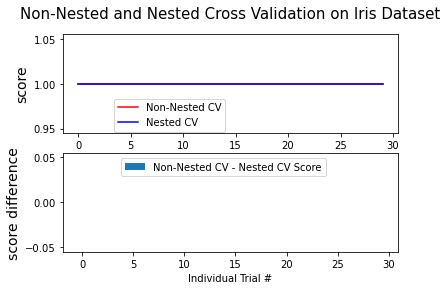

In [33]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# Number of random trials
NUM_TRIALS = 30


# Set up possible values of parameters to optimize over
p_grid = [{"hidden_layer_sizes": [(37,)], "max_iter": [1000]}]

# We will use a Support Vector Classifier with "rbf" kernel
svm = MLPClassifier()

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in tqdm(range(NUM_TRIALS)):
    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=outer_cv)
    clf.fit(X, y)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
    nested_score = cross_val_score(clf, X=X, y=y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print(
    "Average difference of {:6f} with std. dev. of {:6f}.".format(
        score_difference.mean(), score_difference.std()
    )
)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
(non_nested_scores_line,) = plt.plot(non_nested_scores, color="r")
(nested_line,) = plt.plot(nested_scores, color="b")
plt.ylabel("score", fontsize="14")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Non-Nested and Nested Cross Validation on Iris Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1, 0.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()

## ¿Cuál es el mejor clasificador?

* De acuerdo con los resultados de los anteriores apartados, indica cuál es el mejor clasificador encontrado.
    * El DecisionTree después de haber depurado los datos (precisión de 0.83)
* ¿Cuáles son los valores de los hiperparámetros utilizados para configurar y entrenar tal  clasificador?
    * max_depth : 3
    * max_features : 7
    * min_samples_leaf: 196
    * min_samples_split: 40
* ¿cuáles son los valores de los parámetros del clasificador entrenado?
    * n_features : 20
    * n_classes : 2
    * n_outputs : 1
* Proporciona una estimación del error de generalización por validación cruzada, así como de la incertidumbre de dicha estimación.
    * Average difference of 0.033808 with std. dev. of 0.066548.

In [69]:
#Parámetros
svm.fit(X,y)
n_features = svm.n_features_
n_classes = svm.n_classes_
feature_importances = svm.feature_importances_
max_features = svm.max_features_
n_outputs = svm.n_outputs_
classes = svm.classes_
print(n_features)
print(n_classes)
print(feature_importances)
print(max_features)
print(n_outputs)
print(classes)

20
2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
20
1
[1 2]


C:\Users\guill\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The attribute `n_features_` is deprecated in 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


  0%|          | 0/30 [00:00<?, ?it/s]

Average difference of 0.033808 with std. dev. of 0.066548.


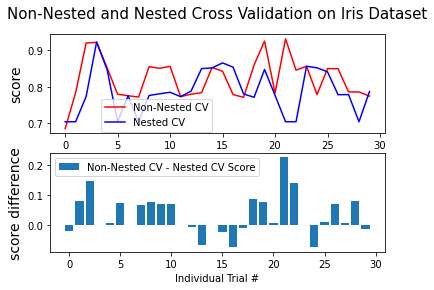

In [38]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# Number of random trials
NUM_TRIALS = 30


# Set up possible values of parameters to optimize over
p_grid = [{'max_depth':[3],'max_features':[7],'min_samples_leaf':[196],'min_samples_split':[40]}]

# We will use a Support Vector Classifier with "rbf" kernel
svm = DecisionTreeClassifier()

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in tqdm(range(NUM_TRIALS)):
    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=outer_cv)
    clf.fit(X, y)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
    nested_score = cross_val_score(clf, X=X, y=y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print(
    "Average difference of {:6f} with std. dev. of {:6f}.".format(
        score_difference.mean(), score_difference.std()
    )
)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
(non_nested_scores_line,) = plt.plot(non_nested_scores, color="r")
(nested_line,) = plt.plot(nested_scores, color="b")
plt.ylabel("score", fontsize="14")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Non-Nested and Nested Cross Validation on Iris Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1, 0.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()

## Conclusiones.

Los árboles de decisión son clasificadores relativamente sencillos con un gran rango de efectividad. Su poder radica en su poder generalizador y pueden ser, como en el caso de los actuales datos, deseables por encima de las redes neuronales, sobre todo si no se cuenta con las capacidades de hardware necesarias para explorar cuál configuración de las mismas puede ser más efectiva para el problema.

Las técnicas de limpieza de los datos tienen un impacto positivo sobre el rendimiento de los clasificadores y siempre deben ser consideradas antes de introducirse en el trabajo con clasificadores.